reference:
https://www.kaggle.com/code/teyang/drivers-of-hdb-resale-price-and-prediction/notebook

# Table of Contents
* [1. Data Loading](#1)
* [2. Data Cleaning](#2)
    * [2.2. Inflation Adjustment Using CPI](#2.1) 
* [3. Explotory Data Analysis](#3)
    * [3.1. By Flat Type](#3.1)
    * [3.2. By Town](#3.2)
    * [3.3. By Storeys](#3.3)
    * [3.4. By Floor Area](#3.4)
    * [3.5. By Block Number](#3.5)
    * [3.6. By Flat Model](#3.6)
    * [3.7. By Lease Commence Date](#3.7)
    * [3.8. By Distance to Nearest Amenities](#3.8)
* [4. Data Preparation](#4)
    * [4.1. Missing Values](#4.1)
    * [4.2. Multicollinearity](#4.2)
    * [4.3. Normality](#4.3)
    * [4.4. Label & Dummy Encoding](#4.4)
    * [4.5. Feature Scaling](#4.5)
    * [4.6. Outlier Detection](#4.6)
* [5. Multiple Linear Regression](#5)
* [6. Model Selection](#6)
    * [6.1. Multiple Linear Regression](*6.1)
    * [6.2. Stochastic Gradient Descent Regression](*6.2)
    * [6.3. Random Forest Regression](*6.3)
    * [6.4. Gradient Boosting Regression](*6.4)
    * [6.5. Extreme Gradient Boosting Regression](*6.5)
        * [6.5.1. HPO & CV](*6.5.1)
    * [6.6. Neural Network Regression](*6.6)

# 1. Data Loading <a class="anchor" id="1"></a>

In [1]:
from datetime import datetime as dt
from yellowbrick.regressor import CooksDistance
from yellowbrick.regressor import ResidualsPlot
import gc
import joypy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.api import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor   # library for VIF

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
price90_99 = pd.read_csv('/Users/tengxianrui/Desktop/Research/For bachelor thesis/HDB resale flats pricing/Singapore HDB Flat Resale Prices (1990-2020)/input/resale-flat-prices-based-on-approval-date-1990-1999.csv')
price00_12 = pd.read_csv('/Users/tengxianrui/Desktop/Research/For bachelor thesis/HDB resale flats pricing/Singapore HDB Flat Resale Prices (1990-2020)/input/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
price12_14 = pd.read_csv('/Users/tengxianrui/Desktop/Research/For bachelor thesis/HDB resale flats pricing/Singapore HDB Flat Resale Prices (1990-2020)/input/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
price15_16 = pd.read_csv('/Users/tengxianrui/Desktop/Research/For bachelor thesis/HDB resale flats pricing/Singapore HDB Flat Resale Prices (1990-2020)/input/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
price17_23 = pd.read_csv('/Users/tengxianrui/Desktop/Research/For bachelor thesis/HDB resale flats pricing/Singapore HDB Flat Resale Prices (1990-2020)/input/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [3]:
price90_99.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200


In [4]:
price00_12.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0


In [5]:
price12_14.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0


In [6]:
price15_16.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


In [7]:
price17_23.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
169579,2024-01,YISHUN,5 ROOM,213,YISHUN ST 21,04 TO 06,121.0,Improved,1985,60 years 01 month,615000.0
169580,2024-01,YISHUN,5 ROOM,505C,YISHUN ST 51,04 TO 06,112.0,Improved,2016,91 years 03 months,640000.0
169581,2024-01,YISHUN,5 ROOM,513C,YISHUN ST 51,07 TO 09,113.0,Improved,2018,93 years 03 months,675000.0
169582,2024-01,YISHUN,5 ROOM,602,YISHUN ST 61,07 TO 09,121.0,Improved,1987,62 years 05 months,688000.0
169583,2024-01,YISHUN,EXECUTIVE,356,YISHUN RING RD,04 TO 06,146.0,Maisonette,1988,63 years 08 months,860000.0


In [8]:
price17_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169584 entries, 0 to 169583
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                169584 non-null  object 
 1   town                 169584 non-null  object 
 2   flat_type            169584 non-null  object 
 3   block                169584 non-null  object 
 4   street_name          169584 non-null  object 
 5   storey_range         169584 non-null  object 
 6   floor_area_sqm       169584 non-null  float64
 7   flat_model           169584 non-null  object 
 8   lease_commence_date  169584 non-null  int64  
 9   remaining_lease      169584 non-null  object 
 10  resale_price         169584 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 14.2+ MB


In [9]:
# Merge dfs
prices = pd.concat([price90_99, price00_12, price12_14], sort=False)
prices = pd.concat([prices, price15_16, price17_23], axis=0, ignore_index=True, sort=False)

prices['month'] = pd.to_datetime(prices['month']) # to datetime

prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915791 entries, 0 to 915790
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                915791 non-null  datetime64[ns]
 1   town                 915791 non-null  object        
 2   flat_type            915791 non-null  object        
 3   block                915791 non-null  object        
 4   street_name          915791 non-null  object        
 5   storey_range         915791 non-null  object        
 6   floor_area_sqm       915791 non-null  float64       
 7   flat_model           915791 non-null  object        
 8   lease_commence_date  915791 non-null  int64         
 9   resale_price         915791 non-null  float64       
 10  remaining_lease      206737 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 76.9+ MB


In [10]:
prices[~prices.isnull().any(axis=1)]['month'].dt.year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

remaining_lease has lots of NAs. They are only available after 2015 sales onwards.

# 2. Data Cleaning <a class="anchor" id="2"></a>

In [11]:
# Clean flat type
prices['flat_type'] = prices['flat_type'].str.replace('MULTI-GENERATION', 'MULTI GENERATION')
prices['flat_type'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION'], dtype=object)

In [12]:
# Rename flat model duplicates
replace_values = {'NEW GENERATION':'New Generation', 'SIMPLIFIED':'Simplified', 'STANDARD':'Standard', 'MODEL A-MAISONETTE':'Maisonette', 'MULTI GENERATION':'Multi Generation', 'IMPROVED-MAISONETTE':'Executive Maisonette', 'Improved-Maisonette':'Executive Maisonette', 'Premium Maisonette':'Executive Maisonette', '2-ROOM':'2-room', 'MODEL A':'Model A', 'MAISONETTE':'Maisonette', 'Model A-Maisonette':'Maisonette', 'IMPROVED':'Improved', 'TERRACE':'Terrace', 'PREMIUM APARTMENT':'Premium Apartment', 'Premium Apartment Loft':'Premium Apartment', 'APARTMENT':'Apartment', 'Type S1':'Type S1S2', 'Type S2':'Type S1S2'}

prices = prices.replace({'flat_model': replace_values})

prices['flat_model'].value_counts()

Model A                 260586
Improved                239140
New Generation          187661
Simplified               57151
Premium Apartment        45744
Standard                 42287
Apartment                35128
Maisonette               31440
Model A2                 10014
DBSS                      3191
Adjoined flat             1234
Terrace                    688
Type S1S2                  642
Multi Generation           539
Executive Maisonette       211
2-room                     109
3Gen                        26
Name: flat_model, dtype: int64

Types of Flat Models:

Standard: (1/2/3/4/5-room). 1960s HDB. Had WC and shower in same room. 5-room Standard were introduced in 1974.

Improved: (1/2/3/4/5-room). Introduced in 1966, the 3/4-room having separate WC and shower, they also featured void decks. 5-room Improved were introduced in 1974.

New Generation: Started first in 1975, New Generation flats can be 3-Room (67 / 82 sqm) or 4-Room (92 sqm), featuring en-suite toilet for master bedroom, with pedestal type Water Closet, plus store room.

Model A: Introduced in 1981: 3-Room (75 sqm), 4-Room (105 sqm), 5-Room (135 sqm), 5-Room Maisonette (139 sqm)

Model A2: Smaller units of Model A. e.g., 4-Room Model A2 (90 sqm)

Simplified: Introduced in 1984: 3-Room (64 sqm), 4-Room (84 sqm)

Multi Generation: 3Gen flats designed to meet the needs of multi-generation families.

Maisonette: AKA Model A Maisonette — 2 storeys HDB flat

Premium Apartment: Introduced somewhere during 1990s, featuring better quality finishes, you get them in ready-to-move condition, with flooring, kitchen cabinets, built-in wardrobes

Executive Maisonette: More premium version of Model A Maisonettes. These units are no longer being built after being replaced by the Executive Condominium (EC) scheme in 1995

Executive Apartment: Executive Apartment / Maisonette (146-150 sqm) were introduced in 1983 and replaced 5-Room Model A flats, in addition of the 3-bedroom and separate living/dining found in 5A flats, EA and EM feature an utility/maid room. 80% of Executive units were Maisonettes and 20% were Apartments.

DBBS: public apartments built under the HDB's short-lived Design, Build and Sell Scheme (DBSS) from 2005 to 2012. They are a unique (and premium) breed of HDB flats in Singapore, which are built by private developers. High Prices. Quite similiar to Executive Condominium except DBBS is like a premium HDB without facilities of private condos

Adjoined Flat: Large HDB flats which are combined from 2 HDB flats

Terrace: HDB terrace flats built before HDB, without realizing Singapore's land constraint. Discontinued

Type S1S2: apartments at The Pinnacle@Duxton are classified as "S" or Special apartments in view of its historical significance and award-winning design. For application of HDB policies, S1 and S2 apartments will be treated as 4-room and 5-room flats respectively

2-room: Most likely refers to 2-room flexi where there is 1 bedroom and 1 common area

In [13]:
prices['storey_range'].unique()

array(['10 TO 12', '04 TO 06', '07 TO 09', '01 TO 03', '13 TO 15',
       '19 TO 21', '16 TO 18', '25 TO 27', '22 TO 24', '28 TO 30',
       '31 TO 33', '40 TO 42', '37 TO 39', '34 TO 36', '06 TO 10',
       '01 TO 05', '11 TO 15', '16 TO 20', '21 TO 25', '26 TO 30',
       '36 TO 40', '31 TO 35', '46 TO 48', '43 TO 45', '49 TO 51'],
      dtype=object)

In [14]:
prices['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI',
       'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'SENGKANG',
       'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN',
       'LIM CHU KANG', 'SEMBAWANG', 'BUKIT PANJANG', 'PASIR RIS',
       'PUNGGOL'], dtype=object)

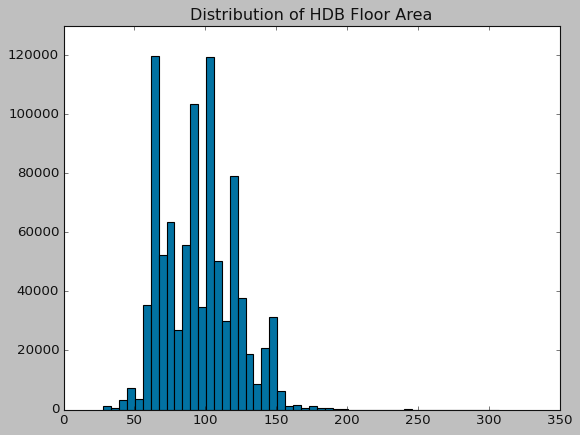

Terrace                 64
Maisonette              16
Executive Maisonette     7
Apartment                4
Adjoined flat            1
Name: flat_model, dtype: int64

In [15]:
plt.style.use('classic')

plt.hist(prices['floor_area_sqm'], bins=50, edgecolor='black')
plt.ylim(0, 130000)
plt.title('Distribution of HDB Floor Area')
plt.show()

display(prices[prices['floor_area_sqm'] > 200]['flat_model'].value_counts())

The floor area outliers mostly belong to special HDBs that are larger than the standard ones. So they might not be outliers from a multivariate perspective.

## 2.1. Inflation Adjustment Using CPI <a class="anchor" id="2.1"></a>

In [16]:
# load data
cpi = pd.read_csv('/Users/tengxianrui/Desktop/Research/For bachelor thesis/HDB resale flats pricing/Singapore HDB Flat Resale Prices (1990-2020)/input/CPI.csv')

In [17]:
cpi.drop(cpi.index[0:9], inplace=True)
cpi.reset_index(drop=True, inplace=True)
cpi.drop(cpi.index[409:], inplace=True)
cpi.drop(cpi.columns[1], axis=1, inplace=True)
cpi.rename(columns={'Unnamed: 0': 'month', 'Unnamed: 2': 'cpi'}, inplace=True)
cpi['cpi'] = cpi['cpi'].astype(float)

In [18]:
# Compute Resale Price Adjusted for Inflation Using Consumer Price Index for Housing & Utilities
# 2019 as base year
# https://www.singstat.gov.sg/find-data/search-by-theme/economy/prices-and-price-indices/latest-data
cpi['month'] = pd.to_datetime(cpi['month'].str.strip(), format='%Y %b') # to datetime
prices = prices.merge(cpi, on='month', how='left')
# https://people.duke.edu/~rnau/411infla.htm
prices['real_price'] = (prices['resale_price'] / prices['cpi']) * 100 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/patches.py:2896: RuntimeWarning: divide by zero encountered in scalar divide
  f1 = self.rad / d1
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/patches.py:2900: RuntimeWarning: invalid value encountered in scalar multiply
  vertices.extend([(cx + dx1 * f1, cy + dy1 * f1),


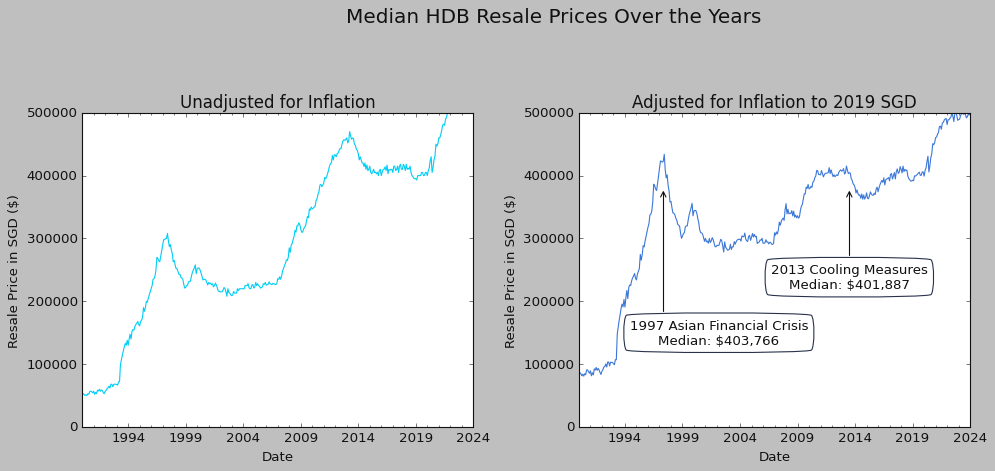

In [19]:
# Plot Median Resale Prices Over the Years

# Unadjusted
fig = plt.figure(figsize=(14,6))
fig.suptitle('Median HDB Resale Prices Over the Years', fontsize=18)
ax1 = fig.add_subplot(121)
prices.groupby('month')[['resale_price']].median().plot(ax=ax1, color='#00cef6', legend=None)
ax1.set_xlabel('Date'), ax1.set_ylabel('Resale Price in SGD ($)'), ax1.set_ylim(0, 500000), ax1.set_title('Unadjusted for Inflation', size=15)

# Adjusted
# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
ax2 = fig.add_subplot(122)
prices.groupby('month')[['real_price']].median().plot(ax=ax2, color='#3c78d8', legend=None)
ax2.set_xlabel('Date'), ax2.set_ylabel('Resale Price in SGD ($)'), ax2.set_ylim(0, 500000), ax2.set_title('Adjusted for Inflation to 2019 SGD',size=15)
ax2.annotate('1997 Asian Financial Crisis\nMedian: $403,766', xy=('1997-05-01',380000), xycoords='data', 
    bbox=dict(boxstyle="round4,pad=.5", fc="none", ec="#28324a"), xytext=(50,-140), textcoords='offset points', ha='center',
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=90,rad=20"))
ax2.annotate('2013 Cooling Measures\nMedian: $401,887', xy=('2013-07-01',380000), xycoords='data', 
    bbox=dict(boxstyle="round4,pad=.5", fc="none", ec="#28324a"), xytext=(0,-90), textcoords='offset points', ha='center',
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=90,rad=20"))  
plt.tight_layout(rect=[0, 0, 0.9, 0.9]) 
# for ax, color in zip([ax1, ax2], ['#3c78d8', '#3c78d8']):
#     plt.setp(tuple(ax.spines.values()), color=color)
#     plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)
plt.show()
#prices.set_index('month').loc['1997']['real_price'].median()

Following the collapse of the thai Baht in July 1997, housing prices in Singapore continue to fall and only started gradually increasing again around 2004. In 2013, it experienced a decline due to 'Propery Market Cooling Measures', such as the Additional Buyer's Stamp Duty (ABSD), Loan-to-Value (LTV) Ratio, and Total Debt Servicing Ratio (TDSR). 

more info: https://www.srx.com.sg/cooling-measures

In [20]:
# Convert remaining_lease to number of years
def getYears(text):
    if isinstance(text, str):
        yearmonth = [int(s) for s in text.split() if s.isdigit()]
        if len(yearmonth) > 1: # if there's year and month
            years = yearmonth[0] + (yearmonth[1]/12)
        else: # if only year
            years = yearmonth[0]
        return years
    else: # if int
        return text

prices['remaining_lease'] = prices['remaining_lease'].apply(lambda x: getYears(x))

In [21]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915791 entries, 0 to 915790
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                915791 non-null  datetime64[ns]
 1   town                 915791 non-null  object        
 2   flat_type            915791 non-null  object        
 3   block                915791 non-null  object        
 4   street_name          915791 non-null  object        
 5   storey_range         915791 non-null  object        
 6   floor_area_sqm       915791 non-null  float64       
 7   flat_model           915791 non-null  object        
 8   lease_commence_date  915791 non-null  int64         
 9   resale_price         915791 non-null  float64       
 10  remaining_lease      206737 non-null  float64       
 11  cpi                  915791 non-null  float64       
 12  real_price           915791 non-null  float64       
dtypes: datetime64[

remaining_lease: In some regions (e.g. Singapore, United Kingdom, etc.), residential properties are leased from the government or landlords rather than freehold. The ownership of the house is returned to the original tenant after a certain period of time (e.g. 99 years).

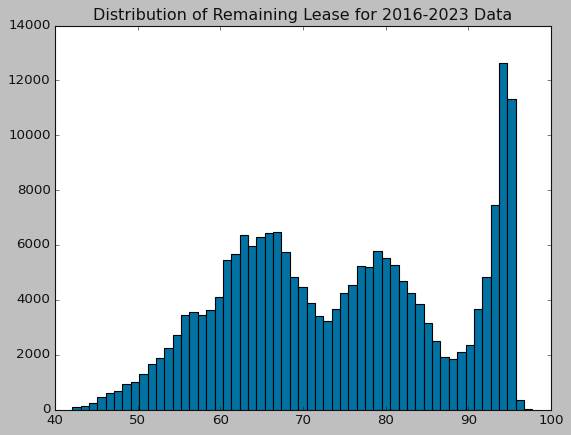

In [22]:
bins = prices['remaining_lease'].max() - prices['remaining_lease'].min()
plt.hist(prices['remaining_lease'], bins=int(bins), edgecolor='black')
plt.title('Distribution of Remaining Lease for 2016-2023 Data')
plt.show()

In [23]:
prices.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,cpi,real_price
915786,2024-01-01,YISHUN,5 ROOM,213,YISHUN ST 21,04 TO 06,121.0,Improved,1985,615000.0,60.083333,113.7,540897.097625
915787,2024-01-01,YISHUN,5 ROOM,505C,YISHUN ST 51,04 TO 06,112.0,Improved,2016,640000.0,91.250000,113.7,562884.784521
915788,2024-01-01,YISHUN,5 ROOM,513C,YISHUN ST 51,07 TO 09,113.0,Improved,2018,675000.0,93.250000,113.7,593667.546174
915789,2024-01-01,YISHUN,5 ROOM,602,YISHUN ST 61,07 TO 09,121.0,Improved,1987,688000.0,62.416667,113.7,605101.143360
915790,2024-01-01,YISHUN,EXECUTIVE,356,YISHUN RING RD,04 TO 06,146.0,Maisonette,1988,860000.0,63.666667,113.7,756376.429200


# 3. Explotory Data Analysis <a class="anchor" id="3"></a>

## 3.1. By Flat Type <a class="anchor" id="3.1"></a>

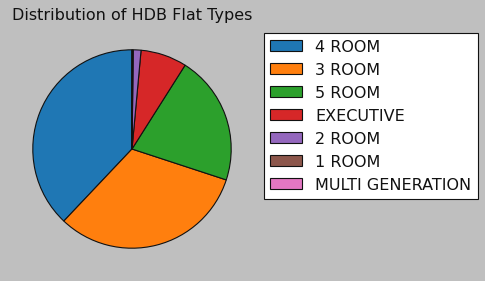

In [24]:
# Set the style for the plots
plt.style.use('classic')

# Get the count of each flat type
flat_type_counts = prices['flat_type'].value_counts()

# Define custom colors for each flat type
colors = plt.cm.get_cmap('tab10').colors

# Plot a pie chart with custom colors
plt.figure(figsize=(4, 4))
pie, _ = plt.pie(flat_type_counts, startangle=90, colors=colors)

# Manually create a legend outside the chart
labels = flat_type_counts.index
plt.legend(pie, labels, loc="upper left", bbox_to_anchor=(1, 1))

plt.title('Distribution of HDB Flat Types')
plt.show()

There are not many 1 Room, 2 Room and Multi Generation flats, so they will be removed for looking at flat types.

In [25]:
flattype = ['3 ROOM','4 ROOM','5 ROOM','EXECUTIVE']
prices1523 = prices.set_index('month').sort_index().loc['2015-01':'2023-12']
prices1523 = prices1523[prices1523['flat_type'].isin(flattype)][['flat_type','real_price']].reset_index()
prices1523['flat_type_year'] = prices1523['flat_type'] + ' - ' + prices1523['month'].apply(lambda x: str(x)[:4])
prices1523

,month,flat_type,real_price,flat_type_year
0,2015-01-01,4 ROOM,305206.463196,4 ROOM - 2015
1,2015-01-01,4 ROOM,304308.797127,4 ROOM - 2015
2,2015-01-01,5 ROOM,852782.764811,5 ROOM - 2015
3,2015-01-01,5 ROOM,740574.506284,5 ROOM - 2015
4,2015-01-01,5 ROOM,738599.640934,5 ROOM - 2015
...,...,...,...,...
202948,2023-12-01,3 ROOM,341312.056738,3 ROOM - 2023
202949,2023-12-01,3 ROOM,336879.432624,3 ROOM - 2023
202950,2023-12-01,3 ROOM,336879.432624,3 ROOM - 2023
202951,2023-12-01,3 ROOM,423758.865248,3 ROOM - 2023


Create two datasets of different size for evaluating models usage later

In [26]:
prices9023 = prices.set_index('month').sort_index().loc['1990-01':'2023-12']
prices9023 = prices9023[prices9023['flat_type'].isin(flattype)][['flat_type','real_price']].reset_index()
prices9023['flat_type_year'] = prices9023['flat_type'] + ' - ' + prices9023['month'].apply(lambda x: str(x)[:4])
prices9023

,month,flat_type,real_price,flat_type_year
0,1990-01-01,3 ROOM,51559.934319,3 ROOM - 1990
1,1990-01-01,3 ROOM,109195.402299,3 ROOM - 1990
2,1990-01-01,3 ROOM,126436.781609,3 ROOM - 1990
3,1990-01-01,3 ROOM,95238.095238,3 ROOM - 1990
4,1990-01-01,3 ROOM,85385.878489,3 ROOM - 1990
...,...,...,...,...
902045,2023-12-01,3 ROOM,341312.056738,3 ROOM - 2023
902046,2023-12-01,3 ROOM,336879.432624,3 ROOM - 2023
902047,2023-12-01,3 ROOM,336879.432624,3 ROOM - 2023
902048,2023-12-01,3 ROOM,423758.865248,3 ROOM - 2023


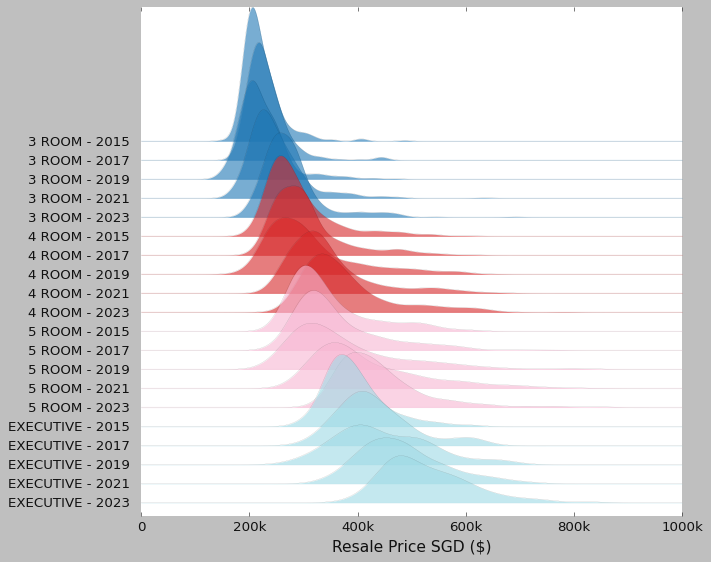

In [27]:
months = ['2015-01-01', '2017-01-01', '2019-01-01', '2021-01-01', '2023-01-01']

fig, axes = joypy.joyplot(prices1523[prices1523['month'].isin(months)], by="flat_type_year", column="real_price", figsize=(9, 7),
                           linewidth=0.1, overlap=2, alpha=0.6, colormap=plt.cm.get_cmap('tab20', 4))

axes[-1].set_xlim([0, 1000000])
axes[-1].set_xticks([0, 200000, 400000, 600000, 800000, 1000000])
axes[-1].set_xticklabels(['0', '200k', '400k', '600k', '800k', '1000k'])

plt.xlabel('Resale Price SGD ($)', fontsize=14)
plt.show()

In [28]:
prices9023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902050 entries, 0 to 902049
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   month           902050 non-null  datetime64[ns]
 1   flat_type       902050 non-null  object        
 2   real_price      902050 non-null  float64       
 3   flat_type_year  902050 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 27.5+ MB


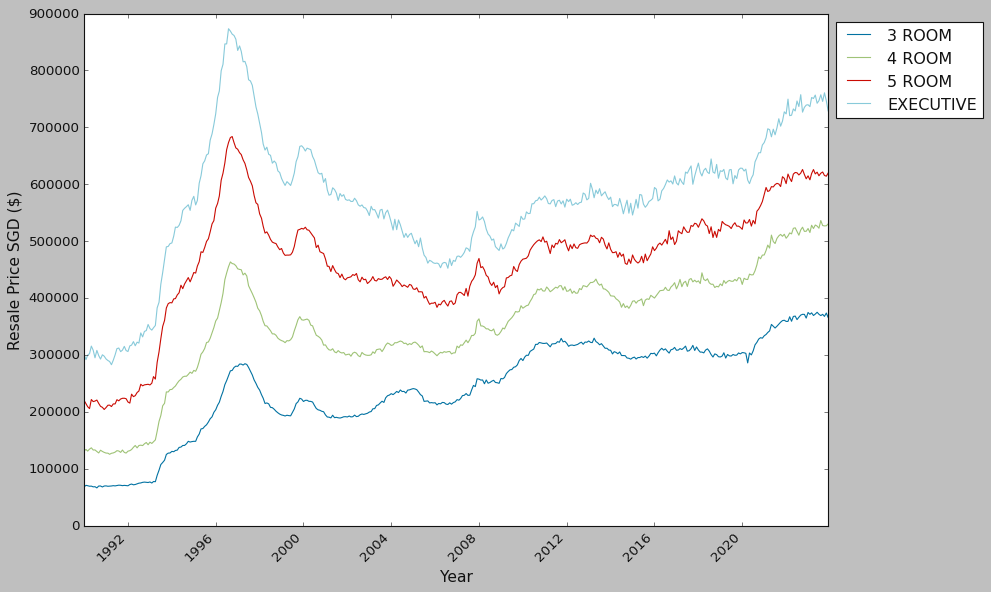

In [29]:
# Set the style for the plots
plt.style.use('classic')

# Create a line plot using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x='month', y='real_price', hue='flat_type', data=prices9023, errorbar=None)

# Format the x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Set labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Resale Price SGD ($)', fontsize=14)

# Show the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## 3.2. By town <a class="anchor" id="3.2"></a>

In [30]:
## 2015 to 2023
prices['year'] = pd.DatetimeIndex(prices['month']).year # extract out year
prices1523_town = prices[prices['year'].isin([2015,2016,2017,2018,2019,2020,2021,2022,2023])].groupby(['town'], as_index=False).agg({'real_price': 'median'}).sort_values('real_price', ascending=True).reset_index(drop=True)
prices1523_town['real_price'] = round(prices1523_town['real_price']/1000)
prices1523_town['color'] = ['#f8766d'] + ['#3c78d8']*(len(prices1523_town)-2) + ['#00ba38']

# 4-room
prices1523_town_4room = prices[(prices['flat_type'].isin(['4 ROOM'])) & (prices['year'].isin([2015,2016,2017,2018,2019,2020,2021,2022,2023]))].groupby(['town'], as_index=False).agg({'real_price': 'median'}).sort_values('real_price', ascending=True).reset_index(drop=True)
prices1523_town_4room['real_price'] = round(prices1523_town_4room['real_price']/1000)
prices1523_town_4room['color'] = ['#f8766d','#f8766d'] + ['#3c78d8']*(len(prices1523_town_4room)-3) + ['#00ba38']

## 1993 vs 2023
# all room type
prices9323_town = prices[prices['year'].isin([1993,2023])].groupby(['town','year'], as_index=False).agg({'real_price': 'median'})
prices9323_town['change'] = prices9323_town.groupby('town')['real_price'].apply(lambda x: x.pct_change()*100)
prices9323_town = prices9323_town[prices9323_town['change'].notnull()] 
prices9323_town = prices9323_town.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices9323_town['color'] = prices9323_town['change'].apply(lambda x: '#00ba38' if x > 0 else '#f8766d')

# 4-room
prices9323_town_4room = prices[(prices['flat_type'].isin(['4 ROOM']) & prices['year'].isin([1993,2023]))].groupby(['town','year'], as_index=False).agg({'real_price': 'median'})
prices9323_town_4room['change'] = prices9323_town_4room.groupby('town')['real_price'].apply(lambda x: x.pct_change()*100)
prices9323_town_4room = prices9323_town_4room[prices9323_town_4room.change.notnull()]
prices9323_town_4room = prices9323_town_4room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices9323_town_4room['color'] = prices9323_town_4room['change'].apply(lambda x: '#00ba38' if x > 0 else '#f8766d')

## 2003 vs 2023
# all room type
prices0323_town = prices[prices['year'].isin([2003,2023])].groupby(['town','year'], as_index=False).agg({'real_price': 'median'})
prices0323_town['change'] = prices0323_town.groupby('town')['real_price'].apply(lambda x: x.pct_change()*100)
prices0323_town = prices0323_town[prices0323_town['change'].notnull()] 
prices0323_town = prices0323_town.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices0323_town['color'] = prices0323_town['change'].apply(lambda x: '#00ba38' if x > 0 else '#f8766d')

# 4-room
prices0323_town_4room = prices[(prices['flat_type'].isin(['4 ROOM']) & prices['year'].isin([2003,2023]))].groupby(['town','year'], as_index=False).agg({'real_price': 'median'})
prices0323_town_4room['change'] = prices0323_town_4room.groupby('town')['real_price'].apply(lambda x: x.pct_change()*100)
prices0323_town_4room = prices0323_town_4room[prices0323_town_4room.change.notnull()]
prices0323_town_4room = prices0323_town_4room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices0323_town_4room['color'] = prices0323_town_4room['change'].apply(lambda x: '#00ba38' if x > 0 else '#f8766d')

## 2022 vs 2023
# all room type
prices2223_town = prices[prices['year'].isin([2022,2023])].groupby(['town','year'], as_index=False).agg({'real_price': 'median'})
prices2223_town['change'] = prices2223_town.groupby('town')['real_price'].apply(lambda x: x.pct_change()*100)
prices2223_town = prices2223_town[prices2223_town['change'].notnull()] 
prices2223_town = prices2223_town.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices2223_town['color'] = prices2223_town['change'].apply(lambda x: '#00ba38' if x > 0 else '#f8766d')

# 4-room
prices2223_town_4room = prices[(prices['flat_type'].isin(['4 ROOM']) & prices['year'].isin([2022,2023]))].groupby(['town','year'], as_index=False).agg({'real_price': 'median'})
prices2223_town_4room['change'] = prices2223_town_4room.groupby('town')['real_price'].apply(lambda x: x.pct_change()*100)
prices2223_town_4room = prices2223_town_4room[prices2223_town_4room.change.notnull()]
prices2223_town_4room = prices2223_town_4room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices2223_town_4room['color'] = prices2223_town_4room['change'].apply(lambda x: '#00ba38' if x > 0 else '#f8766d')

In [31]:
# Function for lollipop charts
def loll_plot(df, x, y, subtitle, xlabel, xlim):
    plt.rc('axes', axisbelow=True)
    plt.grid(linestyle='--', alpha=0.4)
    plt.hlines(y=df.index, xmin=0, xmax=df[x], color=df.color, linewidth=1)
    plt.scatter(df[x], df.index, color=df.color, s=300)
    for i, txt in enumerate(df[x]):
        plt.annotate(str(round(txt)), (txt, i), color='white', fontsize=9, ha='center', va='center')
    plt.annotate(subtitle, xy=(1, 0), xycoords='axes fraction', fontsize=20,
                    xytext=(-5, 5), textcoords='offset points',
                    ha='right', va='bottom')
    plt.yticks(df.index, df[y]); plt.xticks(fontsize=12); plt.xlim(xlim)
    plt.xlabel(xlabel, fontsize=14)

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1596098651.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()])
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1596098651.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax2.get_xticks()])


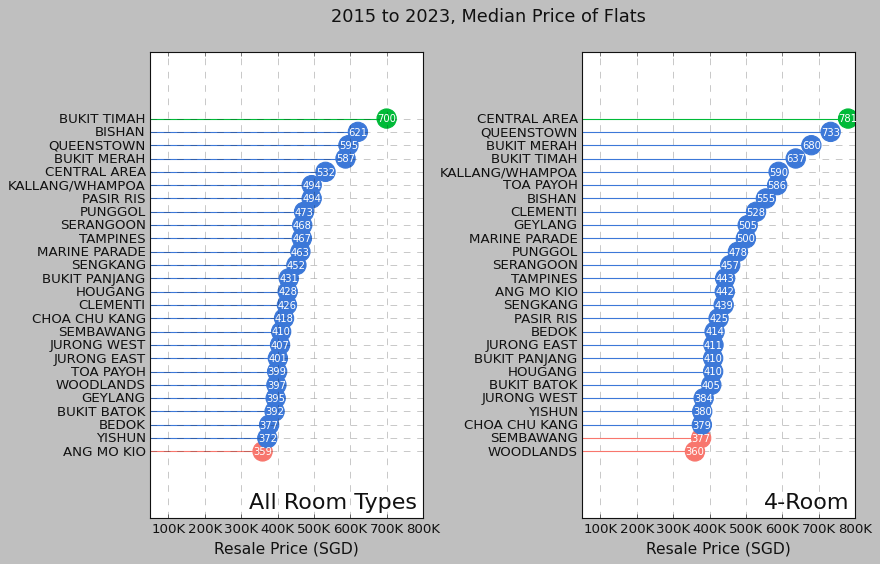

In [32]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices1523_town, 'real_price', 'town', 'All Room Types', 'Resale Price (SGD)', [50,800])
ax1.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()])
ax1.yaxis.set_ticks_position('none') 

ax2 = plt.subplot(122)
loll_plot(prices1523_town_4room, 'real_price', 'town', '4-Room', 'Resale Price (SGD)', [50,800])
ax2.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax2.get_xticks()])
ax2.yaxis.set_ticks_position('none') 

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2015 to 2023, Median Price of Flats', fontsize=16)
plt.show()

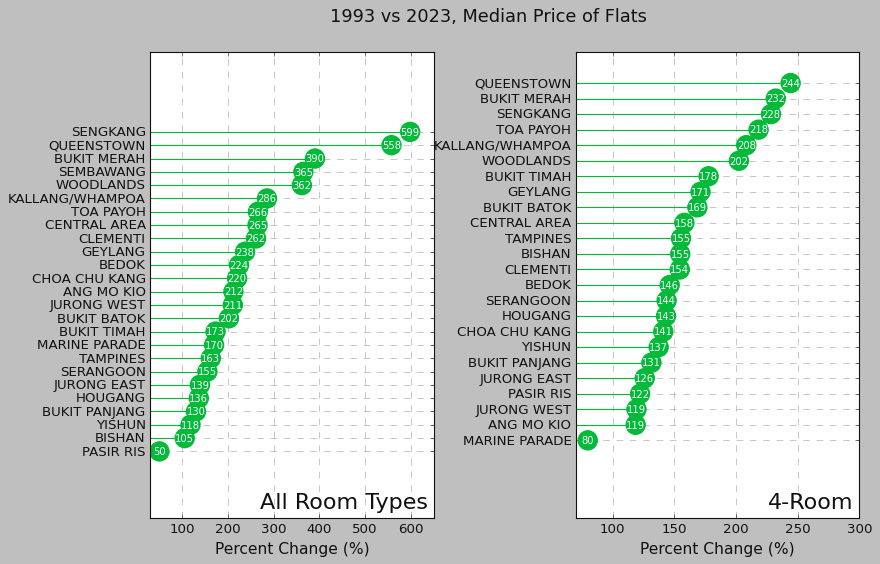

In [33]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices9323_town, 'change', 'town', 'All Room Types', 'Percent Change (%)', [30,650])

ax2 = plt.subplot(122)
loll_plot(prices9323_town_4room, 'change', 'town', '4-Room', 'Percent Change (%)', [70,300])

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('1993 vs 2023, Median Price of Flats', fontsize=16)
plt.show()

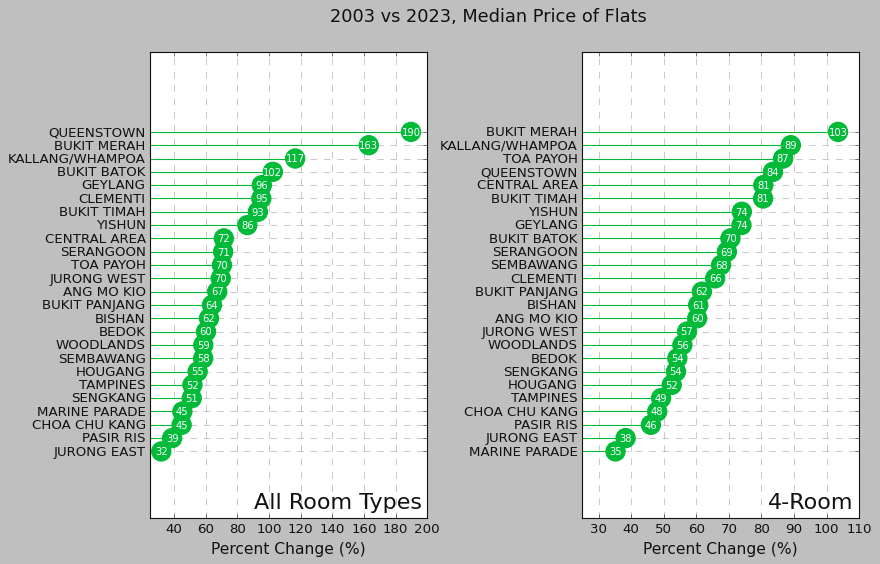

In [34]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices0323_town, 'change', 'town', 'All Room Types', 'Percent Change (%)', [25,200])

ax2 = plt.subplot(122)
loll_plot(prices0323_town_4room, 'change', 'town', '4-Room', 'Percent Change (%)', [25,110])

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2003 vs 2023, Median Price of Flats', fontsize=16)
plt.show()

In [35]:
## 1997 vs 2023
# all room type
prices9723_town = prices[prices['year'].isin([1997,2023])].groupby(['town','year'], as_index=False).agg({'real_price': 'median'})
prices9723_town['change'] = prices9723_town.groupby('town')['real_price'].apply(lambda x: x.pct_change()*100)
prices9723_town = prices9723_town[prices9723_town['change'].notnull()] 
prices9723_town = prices9723_town.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices9723_town['color'] = prices9723_town['change'].apply(lambda x: '#00ba38' if x > 0 else '#f8766d')

# 4-room
prices9723_town_4room = prices[(prices['flat_type'].isin(['4 ROOM']) & prices['year'].isin([1997,2019]))].groupby(['town','year'], as_index=False).agg({'real_price': 'median'})
prices9723_town_4room['change'] = prices9723_town_4room.groupby('town')['real_price'].apply(lambda x: x.pct_change()*100)
prices9723_town_4room = prices9723_town_4room[prices9723_town_4room.change.notnull()]
prices9723_town_4room = prices9723_town_4room.sort_values('change', ascending=True).reset_index(drop=True).reset_index()
prices9723_town_4room['color'] = prices9723_town_4room['change'].apply(lambda x: '#00ba38' if x > 0 else '#f8766d')

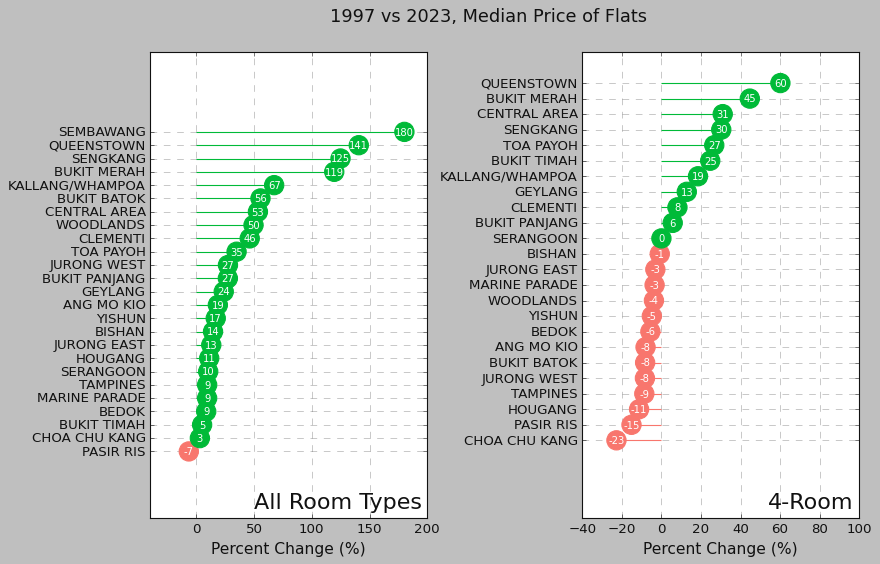

In [36]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices9723_town, 'change', 'town', 'All Room Types', 'Percent Change (%)', [-40,200])

ax2 = plt.subplot(122)
loll_plot(prices9723_town_4room, 'change', 'town', '4-Room', 'Percent Change (%)', [-40,100])

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('1997 vs 2023, Median Price of Flats', fontsize=16)
plt.show()

__Queenstown__ appears to have one of the highest increases in resale price, which could be due to it being developed over the past 2 decades.

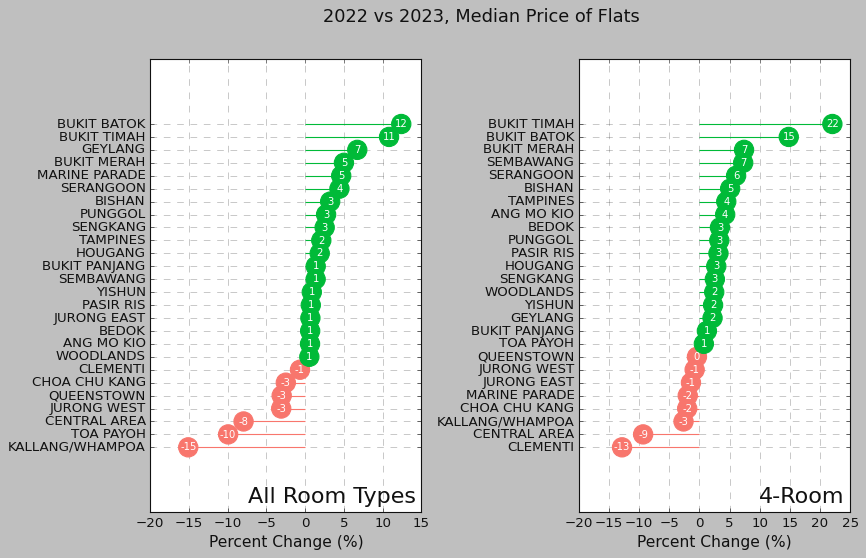

In [37]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(121)
loll_plot(prices2223_town, 'change', 'town', 'All Room Types', 'Percent Change (%)', [-20,15])

ax2 = plt.subplot(122)
loll_plot(prices2223_town_4room, 'change', 'town', '4-Room', 'Percent Change (%)', [-20,25])

fig.tight_layout(pad=0.5, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2022 vs 2023, Median Price of Flats', fontsize=16)
plt.show()

The changes are not very large from 2022 to 2023, although prices for __Kallang/Whampoa__ has dropped and __Clementi__ Area 4-room flats have also dropped by 15%. Could it be because these areas have older HDB meaning their lease are now shorter? As shown below, it seems that places like __Punggol__, and __Sengkang__, tend to have later lease commence date, as they were developed later, which might have led to their slight increase in prices, while places like __Kallang/Whampoa__ and __Clementi__, tend to have older lease commence date.

In [38]:
prices[prices['year'].isin([2022,2023])].groupby('town')['lease_commence_date'].median().sort_values()

town
MARINE PARADE      1975.0
ANG MO KIO         1980.0
BEDOK              1980.0
CLEMENTI           1981.0
CENTRAL AREA       1982.0
GEYLANG            1982.0
JURONG EAST        1984.0
TOA PAYOH          1984.0
SERANGOON          1986.0
KALLANG/WHAMPOA    1987.0
BISHAN             1988.0
BUKIT TIMAH        1988.0
YISHUN             1988.0
TAMPINES           1988.0
HOUGANG            1992.0
PASIR RIS          1993.0
BUKIT BATOK        1997.0
BUKIT MERAH        1997.0
JURONG WEST        1998.0
WOODLANDS          1998.0
CHOA CHU KANG      1999.0
BUKIT PANJANG      1999.0
QUEENSTOWN         2002.0
SENGKANG           2011.0
PUNGGOL            2015.0
SEMBAWANG          2015.0
Name: lease_commence_date, dtype: float64

## 3.3. By Storeys <a class="anchor" id="3.3"></a>

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1973111947.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(ylabels)


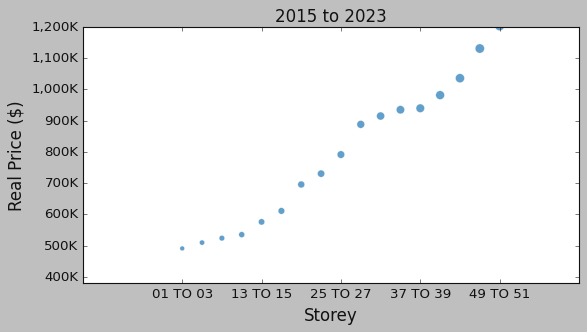

In [39]:
plt.style.use('classic')

plt.figure(figsize=(8, 4))

storey2 = prices[prices['year'].isin([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])].groupby('storey_range')['real_price'].median().reset_index().sort_values(by='storey_range')
storey2['storey_rank'] = storey2['storey_range'].astype('category').cat.codes

# Scatter plot with updated parameters
b = sns.scatterplot(x=storey2['storey_rank'], y=storey2['real_price'], size=storey2['storey_rank'].astype('int') * 30,
                    color='#1f77b4', edgecolors='w', alpha=0.7, legend=False)

# Adjust y-axis labels and appearance
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_yticks() / 1000]
plt.gca().set_yticklabels(ylabels)
plt.gca().set_xticks([0, 4, 8, 12, 16])
plt.gca().set_xticklabels(storey2.iloc[[0, 4, 8, 12, 16], 0])
plt.gca().set_ylim([280000, 1100000])
plt.xlabel('Storey', size=15)
plt.ylabel('Real Price ($)', size=15)
plt.title('2015 to 2023', size=15)

plt.show()

Surprisingly, this follows a linear relationship, with higher storeys being sold at a higher price.

## 3.4. By Floor Area <a class="anchor" id="3.4"></a>

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/3878965264.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


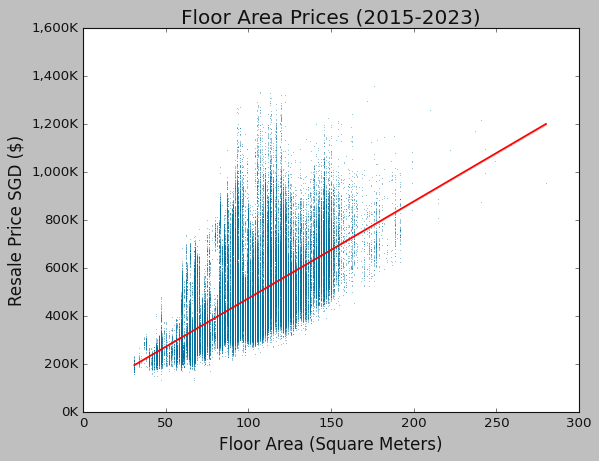

In [40]:
# Filter data for the specified years
area = prices[prices['year'].isin([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])]

# Set a different color palette
# sns.set_palette("coolwarm")
plt.style.use('classic')

# Set a different theme
# sns.set_style("whitegrid")

# Create a scatter plot with regression line
p = sns.regplot(x='floor_area_sqm', y='real_price', data=area, scatter_kws={"s": 0.1, 'alpha': 0.6}, line_kws={"color": "red"})

# Adjust y-axis labels and appearance
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks() / 1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)
p.set_xlabel('Floor Area (Square Meters)', size=15)

plt.title('Floor Area Prices (2015-2023)', size=18)
plt.show()

In [41]:
display(area[area['floor_area_sqm'] > 200])

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,cpi,real_price,year
712167,2015-03-01,KALLANG/WHAMPOA,3 ROOM,53,JLN MA'MOR,01 TO 03,280.0,Terrace,1972,1060000.0,56.000000,111.0,9.549550e+05,2015
716959,2015-06-01,KALLANG/WHAMPOA,3 ROOM,60,JLN BAHAGIA,01 TO 03,241.0,Terrace,1972,958000.0,56.000000,109.3,8.764867e+05,2015
745544,2016-12-01,KALLANG/WHAMPOA,3 ROOM,57,JLN MA'MOR,01 TO 03,259.0,Terrace,1972,1150000.0,54.000000,103.3,1.113262e+06,2016
755075,2017-06-01,KALLANG/WHAMPOA,3 ROOM,38,JLN BAHAGIA,01 TO 03,215.0,Terrace,1972,830000.0,54.083333,102.5,8.097561e+05,2017
760157,2017-09-01,CHOA CHU KANG,EXECUTIVE,641,CHOA CHU KANG ST 64,16 TO 18,215.0,Executive Maisonette,1998,888000.0,79.333333,101.8,8.722986e+05,2017
765900,2017-12-01,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,01 TO 03,249.0,Terrace,1972,1053888.0,53.583333,100.9,1.044488e+06,2017
767035,2018-01-01,CHOA CHU KANG,EXECUTIVE,639,CHOA CHU KANG ST 64,10 TO 12,215.0,Executive Maisonette,1998,900000.0,79.000000,101.2,8.893281e+05,2018
782004,2018-09-01,KALLANG/WHAMPOA,3 ROOM,41,JLN BAHAGIA,01 TO 03,237.0,Terrace,1972,1185000.0,52.833333,101.2,1.170949e+06,2018
836621,2021-03-01,BISHAN,EXECUTIVE,446,BRIGHT HILL DR,07 TO 09,243.0,Maisonette,1990,1092888.0,68.083333,99.8,1.095078e+06,2021
836679,2021-04-01,BISHAN,EXECUTIVE,454,SIN MING AVE,10 TO 12,243.0,Maisonette,1989,1001000.0,67.666667,100.7,9.940417e+05,2021


Those cases on top right of the chart consists of flats that are either Terrace or Executive Maisonette, which is not surprising.

## 3.5. By Block Number <a class="anchor" id="3.5"></a>

3 digit system was introduced in the 1970s, with the 1st digit representing a neighbourhood in a town. So for e.g., AMK neighbourhood 1 starts with 101, and AMK neighbourhood 2 starts with 201. So first digit was separated from last 2 digits and plotted separately

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1582218558.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tmp['blocknum'].apply(lambda x: int(str(x)[0])), y=tmp['real_price'], palette=custom_palette, ax=ax1, **scatter_kws)
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1582218558.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()/1000])
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1582218558.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tmp['blocknum'].apply(lambda x: int(str(x)[1:])), y=tmp['real_price'], palette=custom_palette, ax=ax2, **scatter_kws)
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1582218558.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.s

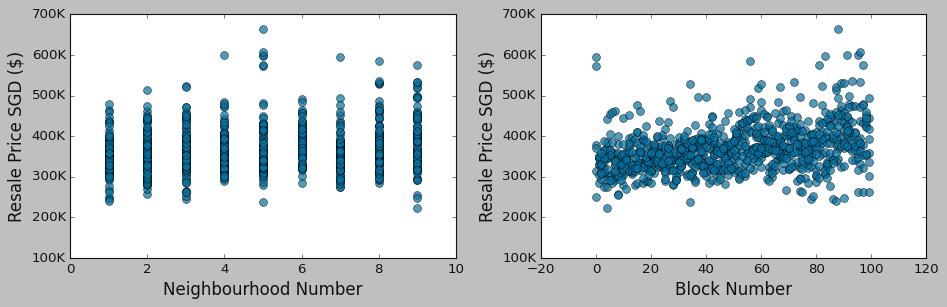

In [42]:
# Block Number Prices
get_num = lambda x: int(re.findall("\d+", x)[0])
prices['blocknum'] = prices['block'].apply(get_num) # get only digits from block number
tmp = prices[prices['blocknum'] > 99] # get only blocks that use 3-digit numbering system
tmp = tmp.groupby('blocknum')['real_price'].median().reset_index()

# Define a custom color palette
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Scatterplot appearance settings
scatter_kws = {"s": 50, "alpha": 0.7, "edgecolor": "black"}  # Marker size, transparency, and edge color

# Create a figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Scatterplot 1: Neighbourhood Number vs. Resale Price
sns.scatterplot(x=tmp['blocknum'].apply(lambda x: int(str(x)[0])), y=tmp['real_price'], palette=custom_palette, ax=ax1, **scatter_kws)
ax1.set_ylabel('Resale Price SGD ($)', size=15)
ax1.set_xlabel('Neighbourhood Number', size=15)
ax1.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()/1000])

# Scatterplot 2: Block Number vs. Resale Price
sns.scatterplot(x=tmp['blocknum'].apply(lambda x: int(str(x)[1:])), y=tmp['real_price'], palette=custom_palette, ax=ax2, **scatter_kws)
ax2.set_ylabel('Resale Price SGD ($)', size=15)
ax2.set_xlabel('Block Number', size=15)
ax2.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax2.get_yticks()/1000])

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

## 3.6. By Flat Model <a class="anchor" id="3.6"></a>

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1895706964.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.violinplot(x='flat_model', y='real_price', data=prices, width=0.9, linewidth=1.5, palette=custom_palette,
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1895706964.py:9: UserWarning: 
The palette list has fewer values (10) than needed (17) and will cycle, which may produce an uninterpretable plot.
  p = sns.violinplot(x='flat_model', y='real_price', data=prices, width=0.9, linewidth=1.5, palette=custom_palette,
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1895706964.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right')
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/189

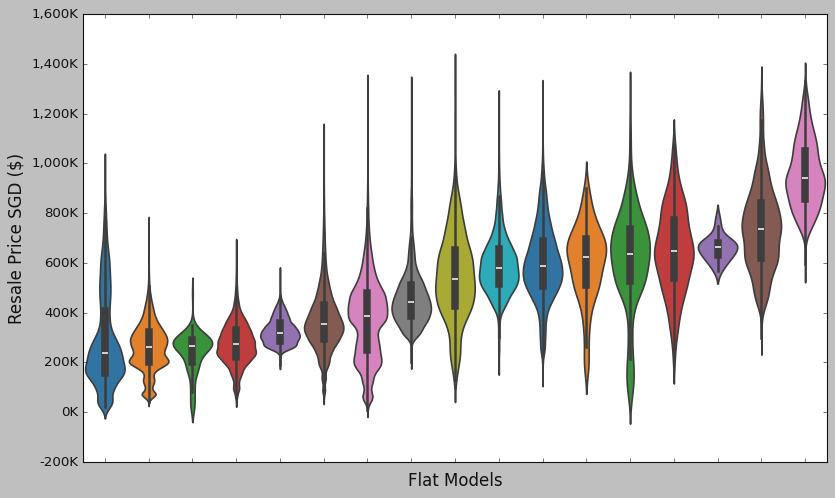

In [82]:
# Violin plots for price distribution of each flat model
# sns.set_style("whitegrid")

# Define a custom color palette
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a violin plot with modified appearance
fig = plt.figure(figsize=(12, 7))
p = sns.violinplot(x='flat_model', y='real_price', data=prices, width=0.9, linewidth=1.5, palette=custom_palette,
                   order=prices.groupby('flat_model')['real_price'].median().sort_values().reset_index()['flat_model'].tolist())

# Rotate x-axis labels for better readability
p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right')
p.set_xlabel('Flat Models', size=15)

# Adjust y-axis labels
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)

plt.show()

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1470761262.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.boxplot(x='flat_model', y='real_price', data=prices, width=0.5, linewidth=1.5, palette=custom_palette,
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1470761262.py:6: UserWarning: 
The palette list has fewer values (10) than needed (17) and will cycle, which may produce an uninterpretable plot.
  p = sns.boxplot(x='flat_model', y='real_price', data=prices, width=0.5, linewidth=1.5, palette=custom_palette,
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1470761262.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right')
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/147076126

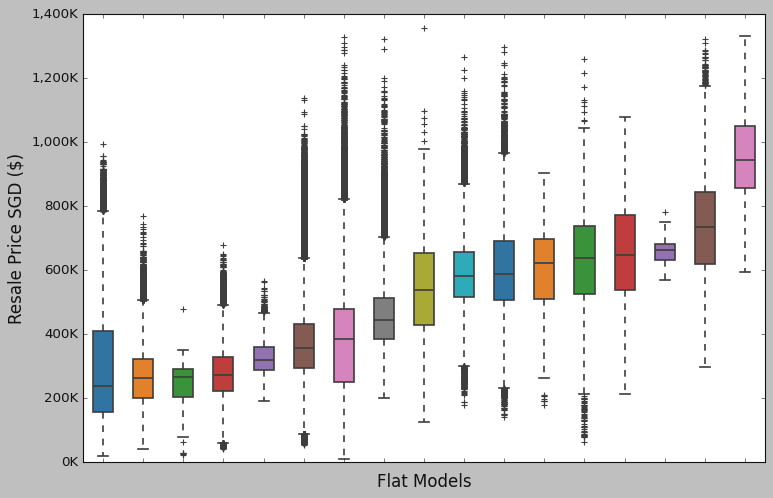

In [44]:
# Define a custom color palette
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a boxplot with modified appearance
fig = plt.figure(figsize=(11, 7))
p = sns.boxplot(x='flat_model', y='real_price', data=prices, width=0.5, linewidth=1.5, palette=custom_palette,
                order=prices.groupby('flat_model')['real_price'].median().sort_values().reset_index()['flat_model'].tolist())

# Rotate x-axis labels for better readability
p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right')
p.set_xlabel('Flat Models', size=15)

# Adjust y-axis labels
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)

plt.show()

The special models like the Type S1S2 (The Pinnacle@Duxton) and Terrace tend to fetch higher prices while the older models from the 1900s tend to go lower.

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (8).

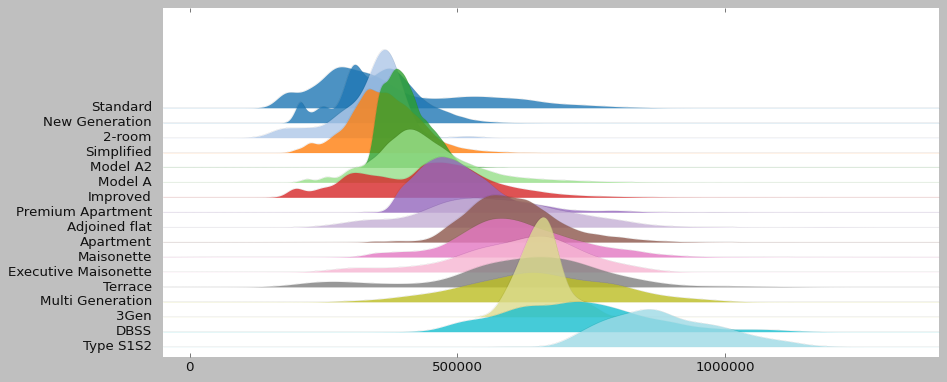

In [84]:
# ridgeline plot

tmp = prices.set_index('flat_model')
tmp = tmp.loc[prices.groupby('flat_model')['real_price'].median().sort_values().reset_index()['flat_model'].tolist()].reset_index().groupby("flat_model", sort=False)
fig, axes = joypy.joyplot(tmp, by="flat_model", column="real_price",figsize=(12,5),
             linewidth=0.05,overlap=1.5,alpha=0.8,colormap=plt.cm.get_cmap('tab20',16))
axes[-1].set_xlim([-50000,1400000])
axes[-1].set_xticklabels(['0', '200k', '400k', '600k', '800k', '1000k', '1200k', '1400k']) 

plt.xlabel('Resale Price SGD ($)', fontsize=14)
fig.show()

## 3.7. By Lease Commence Date <a class="anchor" id="3.7"></a>

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/2720458273.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlabels)


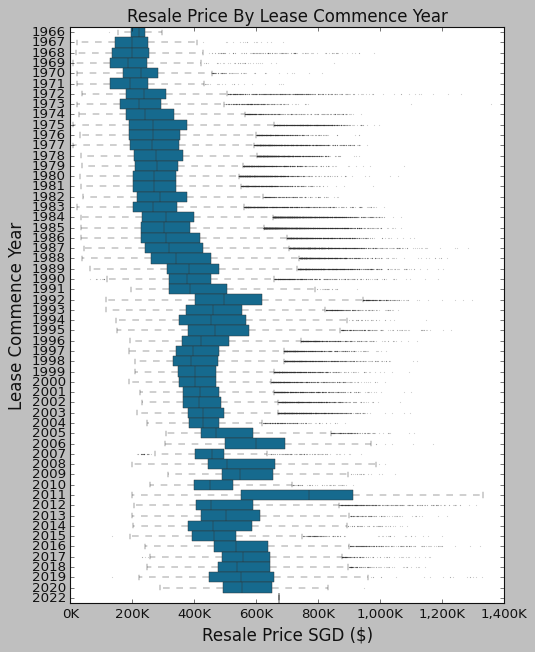

In [46]:
# Boxplot for each year of lease commence date

fig = plt.figure(figsize=(7,9))
p=sns.boxplot(y='lease_commence_date', x='real_price', data=prices, width=1, orient='h', flierprops = dict(markerfacecolor = 'red', markersize = 0.1, linestyle='none'), linewidth=0.4)
p.set_xlabel('Resale Price SGD ($)', size=15), p.set_ylabel('Lease Commence Year', size=15)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlabels)
p.set_title('Resale Price By Lease Commence Year', size=15)
plt.show()

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/797606455.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  p = sns.boxplot(y='lease_commence_date', x='real_price', data=prices, width=0.7, orient='h', palette=custom_palette,
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/797606455.py:6: UserWarning: 
The palette list has fewer values (10) than needed (56) and will cycle, which may produce an uninterpretable plot.
  p = sns.boxplot(y='lease_commence_date', x='real_price', data=prices, width=0.7, orient='h', palette=custom_palette,
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/797606455.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlabels)


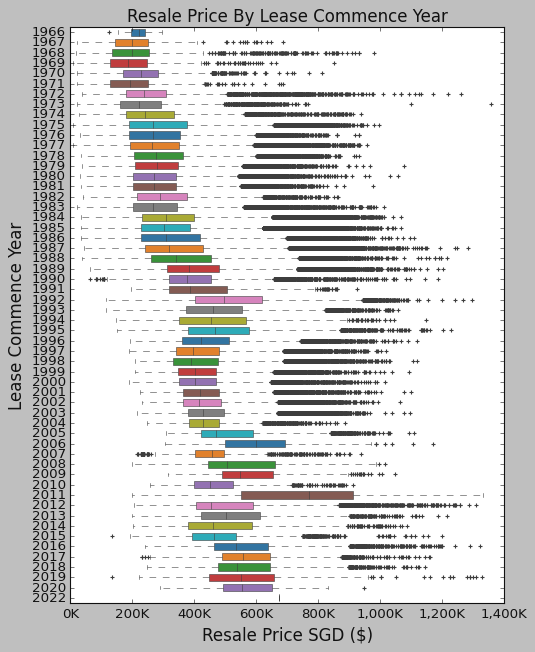

In [47]:
# Define a custom color palette
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a boxplot with modified appearance
fig = plt.figure(figsize=(7, 9))
p = sns.boxplot(y='lease_commence_date', x='real_price', data=prices, width=0.7, orient='h', palette=custom_palette,
                flierprops=dict(markerfacecolor='red', markersize=3, linestyle='none'), linewidth=0.5)

# Set labels and title
p.set_xlabel('Resale Price SGD ($)', size=15)
p.set_ylabel('Lease Commence Year', size=15)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlabels)
p.set_title('Resale Price By Lease Commence Year', size=15)

plt.show()

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/362549812.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


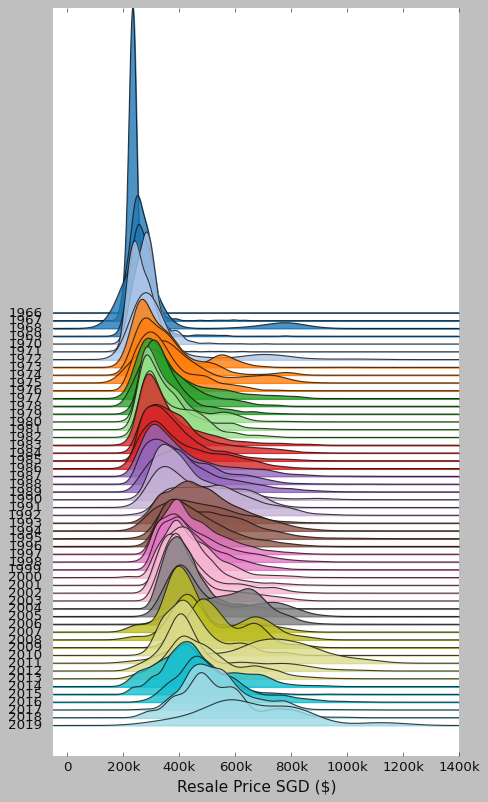

In [48]:
tmp = prices[prices['year'].isin([2015,2016,2017,2018,2019,2020,2021,2022])]
fig, axes = joypy.joyplot(tmp, by="lease_commence_date", column="real_price",figsize=(6,10),
             linewidth=1,overlap=5,alpha=0.8,colormap=plt.cm.get_cmap('tab20',16))
axes[-1].set_xlim([-50000,1400000])
axes[-1].set_xticklabels(['0', '200k', '400k', '600k', '800k', '1000k', '1200k', '1400k']) 
plt.xlabel('Resale Price SGD ($)', fontsize=14)
fig.show()

## 3.8. By Distance to Nearest Amenities <a class="anchor" id="3.8"></a>

In [49]:
flat_amenities = pd.read_csv('/Users/tengxianrui/Desktop/Research/For bachelor thesis/HDB resale flats pricing/Singapore HDB Flat Resale Prices (1990-2020)/input/flat_amenities.csv')

# merge amenities data to flat data
prices1523 = prices[prices['year'].isin([2015,2016,2017,2018,2019,2020,2021,2022,2023])]
prices1523['flat'] = prices['block'] + ' ' + prices['street_name']
prices1523 = prices1523.merge(flat_amenities, on='flat', how='left')

# reduce number of class of town to regions
d_region = {'ANG MO KIO':'North East', 'BEDOK':'East', 'BISHAN':'Central', 'BUKIT BATOK':'West', 'BUKIT MERAH':'Central',
       'BUKIT PANJANG':'West', 'BUKIT TIMAH':'Central', 'CENTRAL AREA':'Central', 'CHOA CHU KANG':'West',
       'CLEMENTI':'West', 'GEYLANG':'Central', 'HOUGANG':'North East', 'JURONG EAST':'West', 'JURONG WEST':'West',
       'KALLANG/WHAMPOA':'Central', 'MARINE PARADE':'Central', 'PASIR RIS':'East', 'PUNGGOL':'North East',
       'QUEENSTOWN':'Central', 'SEMBAWANG':'North', 'SENGKANG':'North East', 'SERANGOON':'North East', 'TAMPINES':'East',
       'TOA PAYOH':'Central', 'WOODLANDS':'North', 'YISHUN':'North'}
prices1523['region'] = prices1523['town'].map(d_region)
colors = {'North East':'Purple', 'East':'Green', 'Central':'Brown', 'West':'Red', 'North':'Orange'}


/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/977003271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices1523['flat'] = prices['block'] + ' ' + prices['street_name']


In [50]:
prices1523.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206326 entries, 0 to 206325
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                206326 non-null  datetime64[ns]
 1   town                 206326 non-null  object        
 2   flat_type            206326 non-null  object        
 3   block                206326 non-null  object        
 4   street_name          206326 non-null  object        
 5   storey_range         206326 non-null  object        
 6   floor_area_sqm       206326 non-null  float64       
 7   flat_model           206326 non-null  object        
 8   lease_commence_date  206326 non-null  int64         
 9   resale_price         206326 non-null  float64       
 10  remaining_lease      206326 non-null  float64       
 11  cpi                  206326 non-null  float64       
 12  real_price           206326 non-null  float64       
 13  year          

* __MRT__ - The Mass Rapid Transit system, locally known by the initialism MRT, is a rapid transit system in Singapore and the island country's principal mode of railway transportation.
* __Hawker__ - A hawker centre or cooked food centre is an open-air complex commonly found in Hong Kong, Malaysia and Singapore.
* __Dhoby__ - Dhoby Ghaut is a place in Singapore that often refers to the Dhoby Ghaut MRT station, a major interchange station on Singapore's Mass Rapid Transit network connecting the North-South Line, North East Line, and the Circle Line. 

In [51]:
prices1523['region'].unique()

array(['North East', 'East', 'Central', 'West', 'North'], dtype=object)

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1734090670.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels), ax.set_ylabel('Resale Price SGD ($)', size=15)


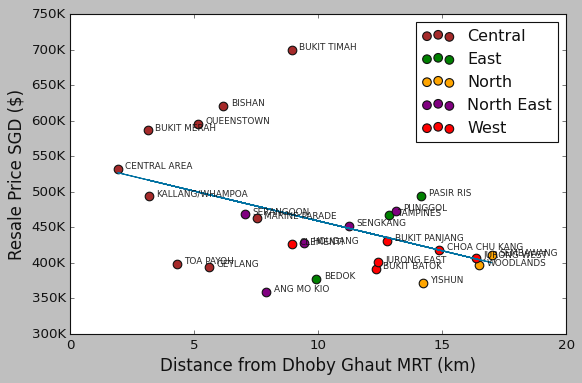

In [52]:
# get median info of each town
tmp = prices1523.groupby('town')[['dist_dhoby','school_dist','num_school_2km','hawker_dist','num_hawker_2km','park_dist','num_park_2km','mall_dist','num_mall_2km','mrt_dist','num_mrt_2km','supermarket_dist','num_supermarket_2km','real_price']].median().reset_index()
tmp['region'] = tmp['town'].map(d_region)

# Scatterplot with names of towns
fig, ax = plt.subplots(figsize=(8,5))
grouped = tmp.groupby('region')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='dist_dhoby', y='real_price', label=key, color=colors[key], s=60)
b, a = np.polyfit(tmp['dist_dhoby'], tmp['real_price'], 1)
ax.plot(tmp['dist_dhoby'], a + b* tmp['dist_dhoby'], '-')  
ax.set_xlim([0,20]), ax.set_xlabel('Distance from Dhoby Ghaut MRT (km)', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels), ax.set_ylabel('Resale Price SGD ($)', size=15)
for i, txt in enumerate(tmp['town']):
    ax.annotate(txt, (tmp['dist_dhoby'][i]+0.3, tmp['real_price'][i]), size=8, alpha=0.9)

plt.show()

In [53]:
prices1523.groupby('region')['real_price'].median()

region
Central       523198.420533
East          449172.105639
North         390199.637024
North East    445891.783567
West          412408.759124
Name: real_price, dtype: float64

Relationship is negative, with flats that are further away from Dhoby Ghaut MRT (Central), having lower resale prices.

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/614243115.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)


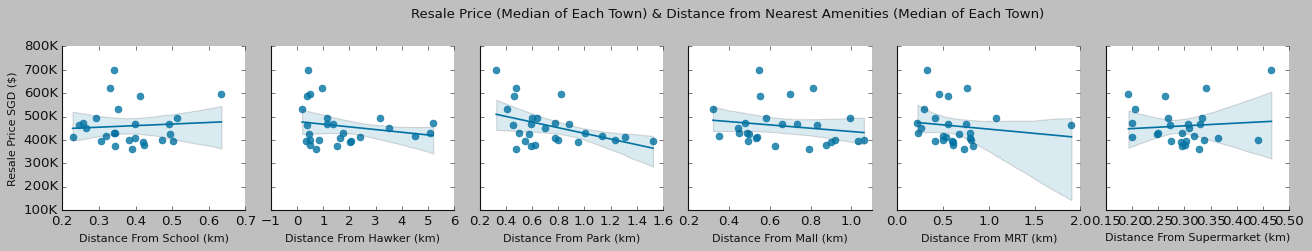

In [56]:
# scatterplot for median price of each town against nearest distance from each amenity

p=sns.pairplot(tmp, x_vars=["school_dist", "hawker_dist", "park_dist", "mall_dist", "mrt_dist", "supermarket_dist"], y_vars=["real_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=40)))
axes=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in axes[0,0].get_yticks()/1000]
axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)
axes[0,0].set_xlabel('Distance From School (km)', size=10), axes[0,1].set_xlabel('Distance From Hawker (km)', size=10)
axes[0,2].set_xlabel('Distance From Park (km)', size=10), axes[0,3].set_xlabel('Distance From Mall (km)', size=10)
axes[0,4].set_xlabel('Distance From MRT (km)', size=10), axes[0,5].set_xlabel('Distance From Supermarket (km)', size=10)
plt.suptitle('Resale Price (Median of Each Town) & Distance from Nearest Amenities (Median of Each Town)')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/3182525161.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


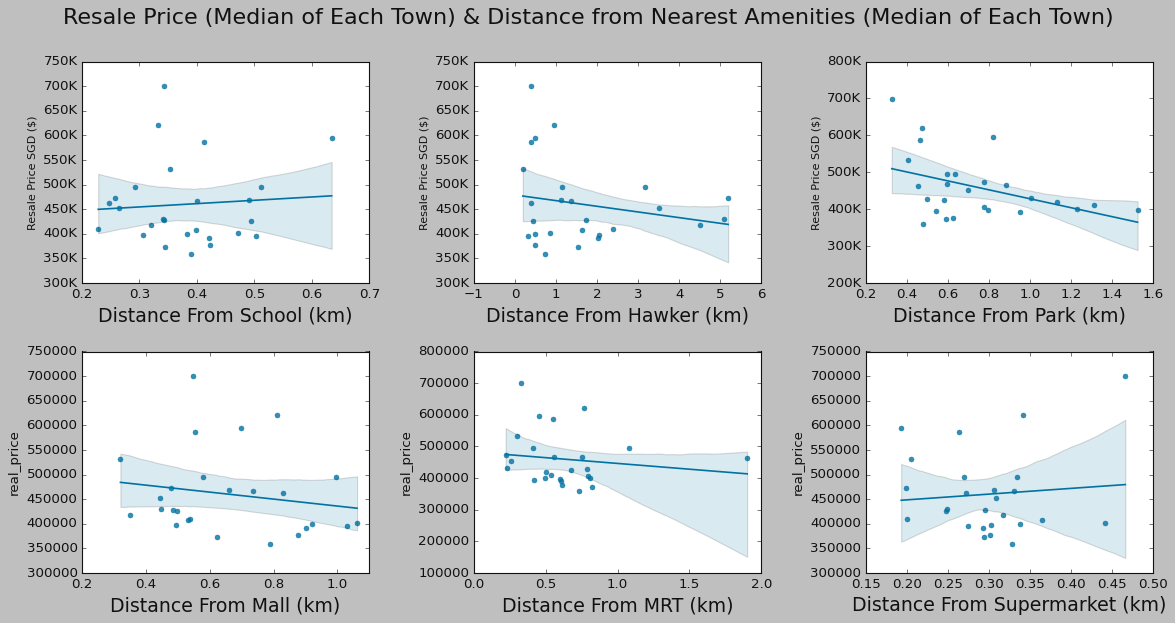

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
i = list(range(3))
xlbls0 = ["School",'Hawker', 'Park']
xlbls1 = ['Mall', 'MRT', 'Supermarket']

# First row of pairplot
sns.regplot(x="school_dist", y="real_price", data=tmp, ax=axes[0, 0])
sns.regplot(x="hawker_dist", y="real_price", data=tmp, ax=axes[0, 1])
sns.regplot(x="park_dist", y="real_price", data=tmp, ax=axes[0, 2])

# Second row of pairplot
sns.regplot(x="mall_dist", y="real_price", data=tmp, ax=axes[1, 0])
sns.regplot(x="mrt_dist", y="real_price", data=tmp, ax=axes[1, 1])
sns.regplot(x="supermarket_dist", y="real_price", data=tmp, ax=axes[1, 2])

# Adjust y-axis labels and appearance for the first row
i = 0
for ax in axes[0, :]:
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Resale Price SGD ($)', size=10)
    ax.set_xlabel('Distance From {} (km)'.format(xlbls0[i]), size=17)
    i += 1

# Set x-axis labels for the second row
i = 0
for ax in axes[1, :]:
    ax.set_xlabel('Distance From Amenity (km)', size=15)
    ax.set_xlabel('Distance From {} (km)'.format(xlbls1[i]), size=17)
    i += 1

# Adjust layout
plt.suptitle('Resale Price (Median of Each Town) & Distance from Nearest Amenities (Median of Each Town)', fontsize=20)
plt.tight_layout(pad=1.5)
plt.show()

Punggol has its own LRT and Central Area has lots of stations and malls nearby.

# 4. Data Preparation <a class="anchor" id="4"></a>

Focus on only data from 2015 to 2023

In [85]:
# clear unused variables
# del(price1999, price2012, price2014, price2016, price2017, prices1819, prices1819_4room, prices9719, prices9719_4room,
#     storey, storey2, tmp, xlabels, ylabels, p, grouped, flattype, flat_amenities, cpi, ax, ax1, ax2, area)

gc.collect()

64127

## 4.1. Missing Values <a class="anchor" id="4.1"></a>

Replace missing distance values with median of the town. Only Kallang/Whampoa has missing data, so the function below will replace them with the median of the Kallang/Whampoa distance variables.

In [86]:
df = prices1523[['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'year', 'school_dist', 'num_school_2km', 'hawker_dist', 'num_hawker_2km', 'park_dist', 'num_park_2km', 'mall_dist', 'num_mall_2km', 'mrt_dist', 'num_mrt_2km', 'supermarket_dist', 'num_supermarket_2km', 'dist_dhoby', 'region', 'real_price']]

# function for replacing NAs with median of the town
def replace_NA_median(df, columns):
    for c in columns:      
        df[c] = df.groupby("town").transform(lambda x: x.fillna(x.median()))[c]
    return df

df = replace_NA_median(df, ['school_dist', 'num_school_2km', 'hawker_dist',
       'num_hawker_2km', 'park_dist', 'num_park_2km', 'mall_dist',
       'num_mall_2km', 'mrt_dist', 'num_mrt_2km', 'supermarket_dist',
       'num_supermarket_2km', 'dist_dhoby'])

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1758422968.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df[c] = df.groupby("town").transform(lambda x: x.fillna(x.median()))[c]
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1758422968.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df[c] = df.groupby("town").transform(lambda x: x.fillna(x.median()))[c]
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1758422968.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, sel

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1758422968.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df[c] = df.groupby("town").transform(lambda x: x.fillna(x.median()))[c]
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1758422968.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df[c] = df.groupby("town").transform(lambda x: x.fillna(x.median()))[c]
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1758422968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1758422968.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df[c] = df.groupby("town").transform(lambda x: x.fillna(x.median()))[c]
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1758422968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df.groupby("town").transform(lambda x: x.fillna(x.median()))[c]
/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/1758422968.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future 

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206326 entries, 0 to 206325
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 206326 non-null  object 
 1   flat_type            206326 non-null  object 
 2   storey_range         206326 non-null  object 
 3   floor_area_sqm       206326 non-null  float64
 4   flat_model           206326 non-null  object 
 5   lease_commence_date  206326 non-null  int64  
 6   year                 206326 non-null  int64  
 7   school_dist          206326 non-null  float64
 8   num_school_2km       206326 non-null  float64
 9   hawker_dist          206326 non-null  float64
 10  num_hawker_2km       206326 non-null  float64
 11  park_dist            206326 non-null  float64
 12  num_park_2km         206326 non-null  float64
 13  mall_dist            206326 non-null  float64
 14  num_mall_2km         206326 non-null  float64
 15  mrt_dist         

## 4.2. Multicollinearity <a class="anchor" id="4.2"></a>

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. Multicollinearity can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.

If our goal is one of classification or prediction and not to look at the importance or contribution of each feature, we do not need to deal with multicollinearity as it does not affect the overall prediction or goodness of fit. It just affects the p-value and the coefficients. But since we are interested in feature importance by looking at the coefficients of the linear regression model, we have to focus on it.

* If the largest VIF is greater than 10 then there is cause for concern (Bowerman & O’Connell, 1990; Myers, 1990)
* If the average VIF is substantially greater than 1 then the regression may be biased (Bowerman & O’Connell, 1990).
* Tolerance below 0.1 indicates a serious problem.
* Tolerance below 0.2 indicates a potential problem (Menard, 1995).


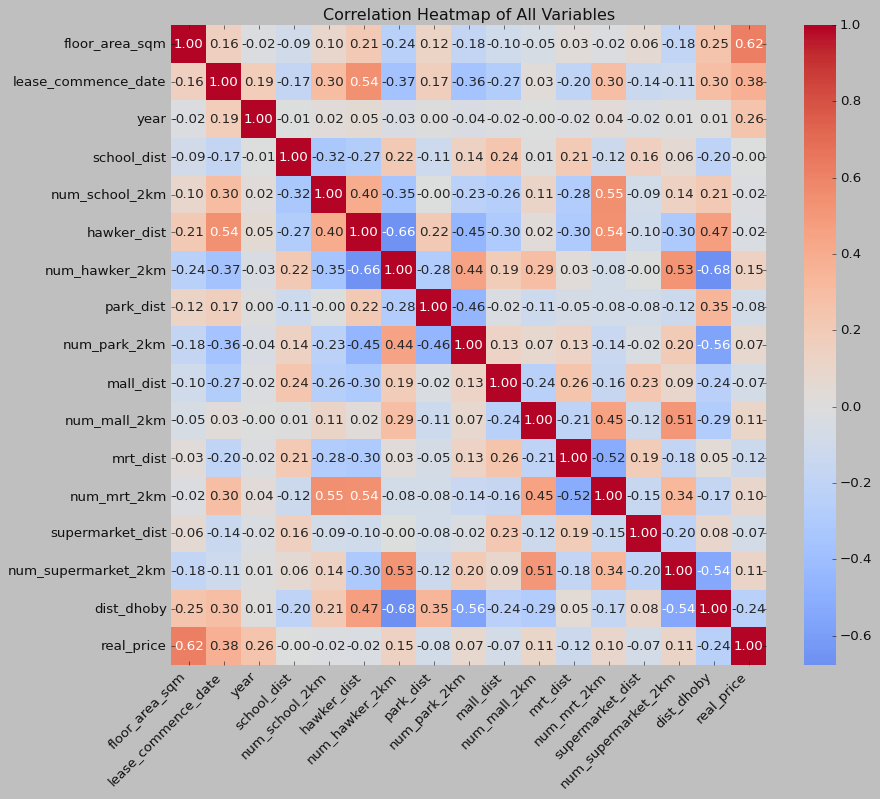

In [88]:
# Compute the correlation matrix
corr = df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap of All Variables')
plt.show()

In [89]:
# Multicollinearity

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

calc_vif(df.drop('real_price',axis=1).select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,floor_area_sqm,19.190287,0.052110,4189.067471
1,lease_commence_date,33517.371947,0.000030,4189.067471
2,year,33349.663770,0.000030,4189.067471
3,school_dist,4.841574,0.206544,4189.067471
4,num_school_2km,15.985798,0.062556,4189.067471
5,hawker_dist,12.115071,0.082542,4189.067471
6,num_hawker_2km,5.346653,0.187033,4189.067471
7,park_dist,6.348732,0.157512,4189.067471
8,num_park_2km,5.194570,0.192509,4189.067471
9,mall_dist,6.209705,0.161038,4189.067471


In [90]:
calc_vif(df.drop(['real_price','num_supermarket_2km','year','num_school_2km','dist_dhoby'],axis=1)
         .select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,floor_area_sqm,19.072188,0.052432,10.798079
1,lease_commence_date,54.504094,0.018347,10.798079
2,school_dist,4.465937,0.223917,10.798079
3,hawker_dist,9.061026,0.110363,10.798079
4,num_hawker_2km,4.100687,0.243862,10.798079
5,park_dist,6.231755,0.160468,10.798079
6,num_park_2km,4.336151,0.230619,10.798079
7,mall_dist,5.610869,0.178225,10.798079
8,num_mall_2km,5.873246,0.170264,10.798079
9,mrt_dist,5.414730,0.184681,10.798079


* VIF = 1：没有多重共线性。系数估计的方差没有膨胀。
* VIF介于1和5之间：中等程度的多重共线性。系数估计的方差有适度的膨胀。
* VIF > 5：严重的多重共线性。系数估计的方差高度膨胀，表明存在强烈的多重共线性。

In [91]:
# drop columns
lr_df = df.drop(['num_supermarket_2km','year','num_school_2km','dist_dhoby'], axis=1)

There is definitely multicollinearity in our continuous features. Even after removing several features, the highest VIF is still around 50 (__lease_commence_date__) and __floor_area_sqm__ is above 10 as well. I chose to left them in as I believe that they are really important contributors to resale prices. One way is to refit another model without them and compare the output.

## 4.3. Normality <a class="anchor" id="4.3"></a>

In [92]:
lr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206326 entries, 0 to 206325
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 206326 non-null  object 
 1   flat_type            206326 non-null  object 
 2   storey_range         206326 non-null  object 
 3   floor_area_sqm       206326 non-null  float64
 4   flat_model           206326 non-null  object 
 5   lease_commence_date  206326 non-null  int64  
 6   school_dist          206326 non-null  float64
 7   hawker_dist          206326 non-null  float64
 8   num_hawker_2km       206326 non-null  float64
 9   park_dist            206326 non-null  float64
 10  num_park_2km         206326 non-null  float64
 11  mall_dist            206326 non-null  float64
 12  num_mall_2km         206326 non-null  float64
 13  mrt_dist             206326 non-null  float64
 14  num_mrt_2km          206326 non-null  float64
 15  supermarket_dist 

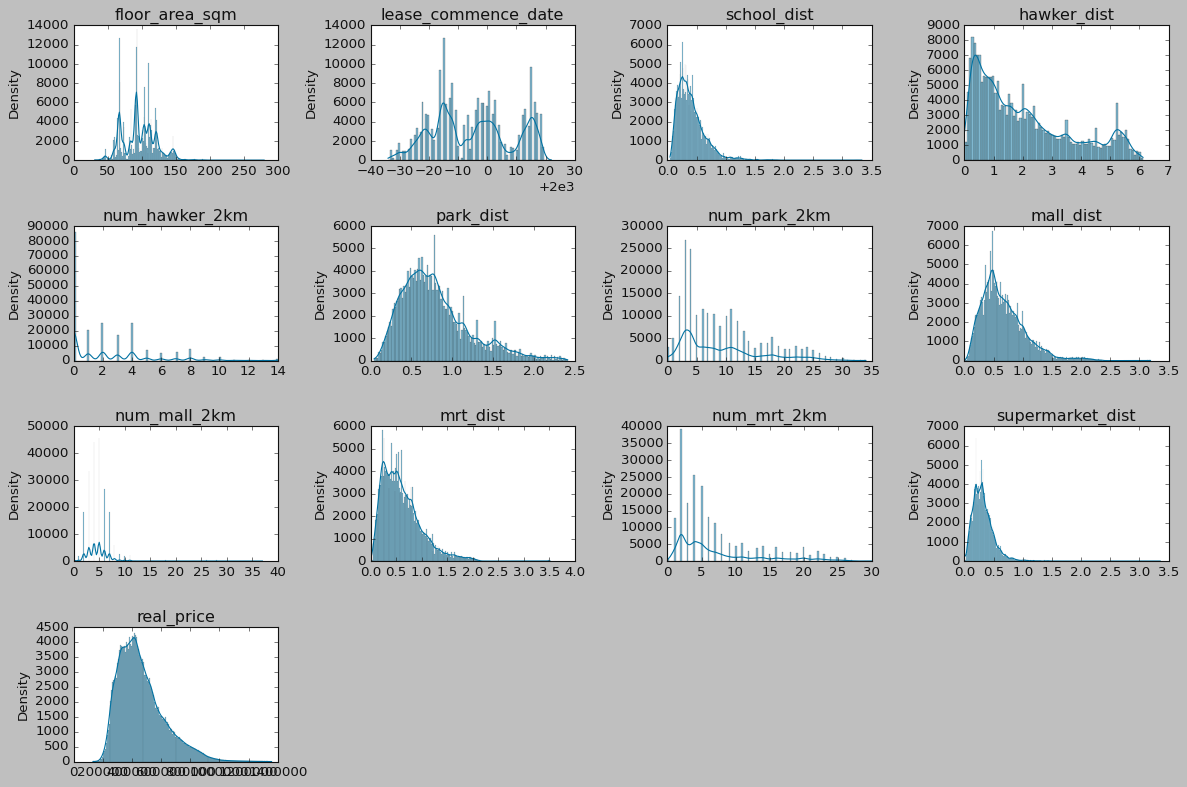

In [93]:
# Plot distribution for each continuous variable

# Select only continuous variables
continuous_columns = ['floor_area_sqm', 'lease_commence_date', 'school_dist', 'hawker_dist', 
                      'num_hawker_2km', 'park_dist', 'num_park_2km', 'mall_dist', 'num_mall_2km', 
                      'mrt_dist', 'num_mrt_2km', 'supermarket_dist', 'real_price']

# Plot density plot for each continuous variable
plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

Not all the variables follow a normal distribution, and most of the __distances variables__ have some __outliers__. For these outliers, its better to use a multivariable approach like mahalanobis distance to see if they are outliers instead of using a univariate approach. If needed, some of these variables can be transformed to reduce the __skewness__.

skewness - 偏度

多变量方法 如马氏距离

多变量方法可以考虑各个变量之间的关系 而不仅仅是单个变量的分布

在异常值检测中 如果仅仅依靠单个变量的分布来识别异常值 可能会忽略变量之间的相关性和交互影响

马氏距离是一种多变量方法 它考虑了数据点相对于数据集中其他数据点的整体分布情况 而不仅仅是某个变量的值

它通过考虑数据的协方差矩阵来度量数据点与数据集中心的距离 从而更准确地识别异常值

/var/folders/8w/9hnksrkn59lcdz1fkwj414x80000gn/T/ipykernel_85167/563859712.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45, ha='right')  # 倾斜向下显示


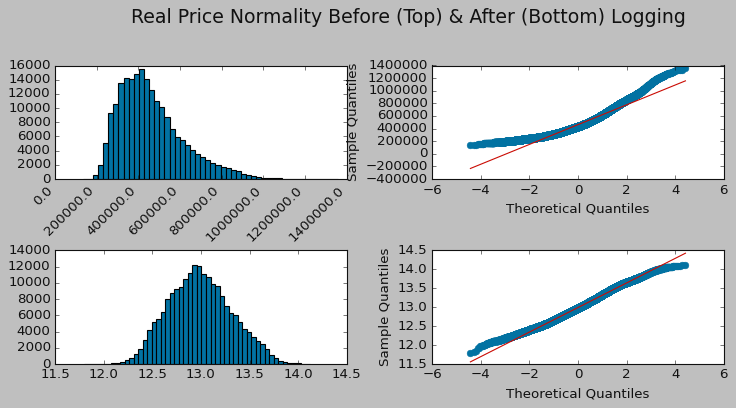

In [99]:
# plot qqplot before and after log transformation

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(10,5))

ax1.hist(lr_df['real_price'], bins=50, edgecolor='black')
ax1.set_xticklabels(ax1.get_xticks(), rotation=45, ha='right')  # 倾斜向下显示
qqplot(lr_df['real_price'], line='s', ax=ax2)
ax3.hist(np.log(lr_df['real_price']), bins=50, edgecolor='black')
qqplot(np.log(lr_df['real_price']), line='s', ax=ax4)
plt.suptitle('Real Price Normality Before (Top) & After (Bottom) Logging', fontsize=17)
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

We will fit the linear regression first and come back to check on the normality of the residuals as well as homoscedasticity. - 同方差性

## 4.4. Label & Dummy Encoding <a class="anchor" id="4.4"></a>

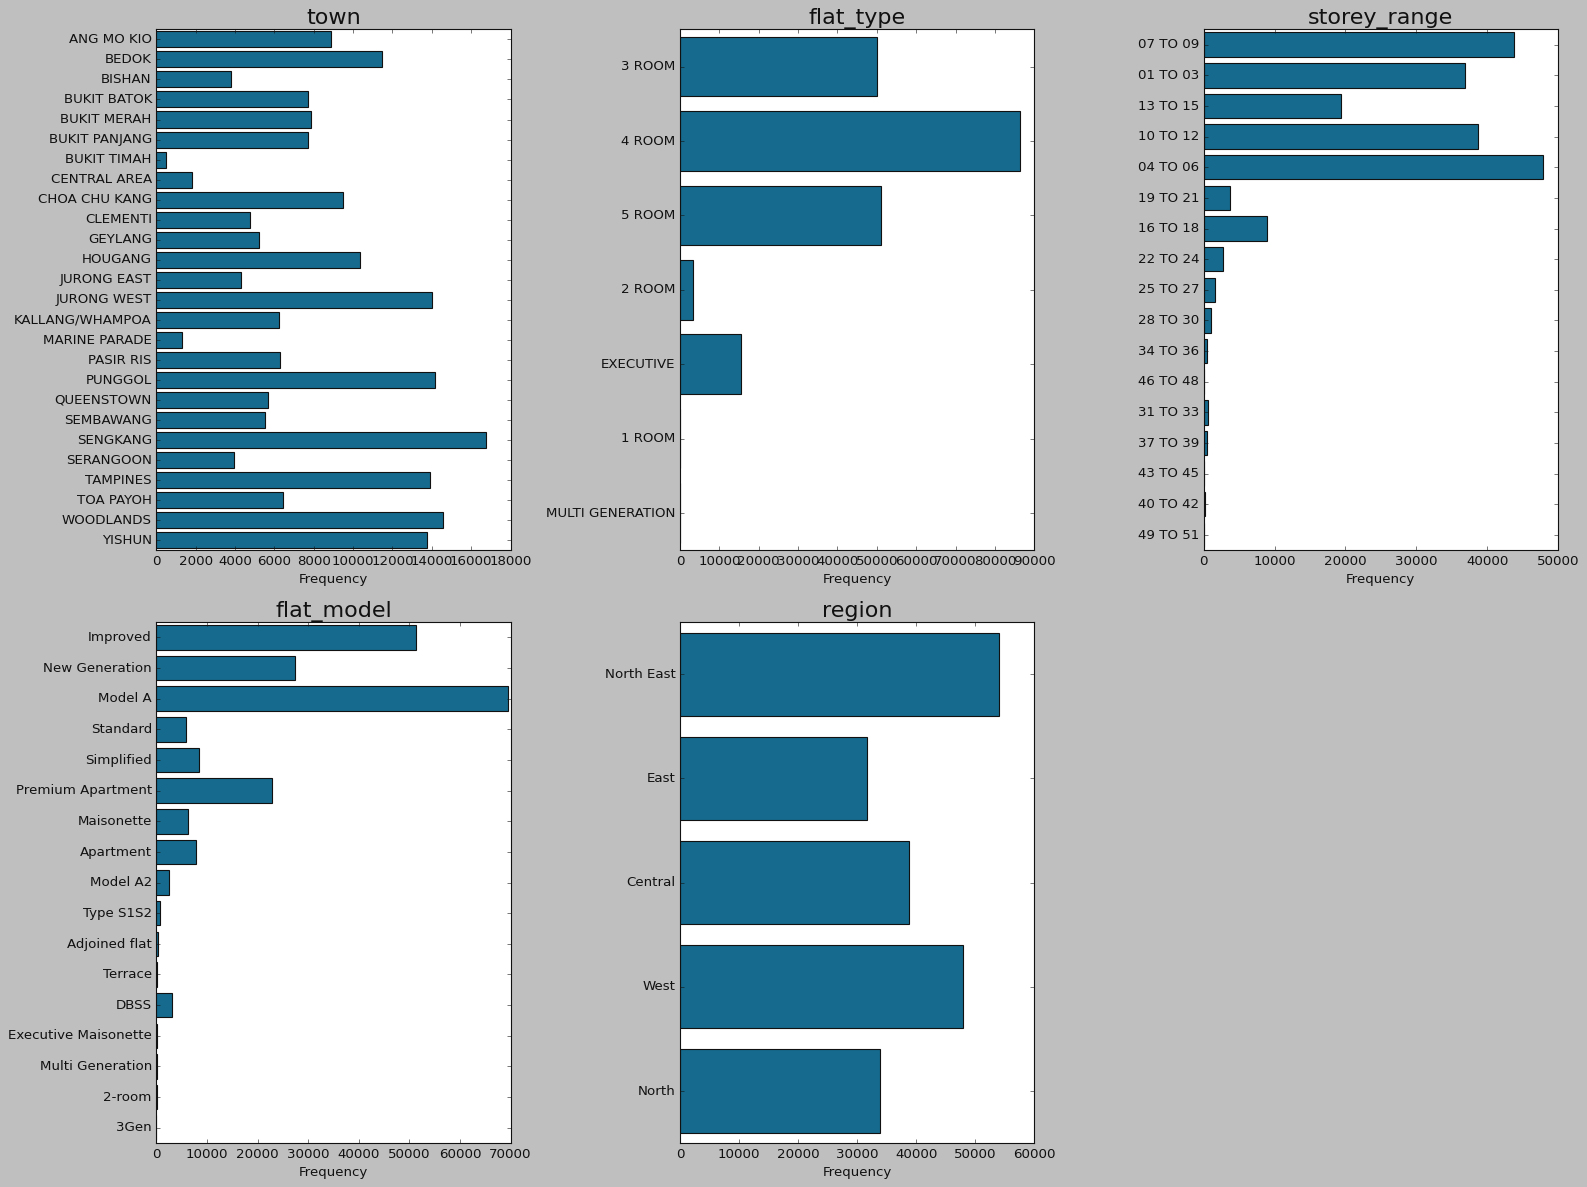

In [100]:
# 提取分类variable
categorical_columns = ['town', 'flat_type', 'storey_range', 'flat_model', 'region']

# 绘制频率图
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=lr_df, y=col)
    plt.title(col, fontsize=20)
    plt.xlabel('Frequency')
    plt.ylabel('')
    
plt.tight_layout()

* __Region__ might be a better choice instead of town since town has lots of classes and one-hot encoding it might lead to __a very sparse matrix__. 
* For flat_type, we can __remove Multi Generation and 1 Room__ since there are not many instances of them. 
* __storey_range__ will be label encoded according to their levels.
* __flat_model__ should be further grouped to reduce the number of classes.

In [101]:
# label encode storeys
df = df.sort_values(by='storey_range')
df['storey_range'] = df['storey_range'].astype('category').cat.codes # label encode
lr_df = lr_df.sort_values(by='storey_range')
lr_df['storey_range'] = lr_df['storey_range'].astype('category').cat.codes # label encode

# remove flat types with very few cases
df = df[~df['flat_type'].isin(['MULTI GENERATION', '1 ROOM'])]
lr_df = lr_df[~lr_df['flat_type'].isin(['MULTI GENERATION', '1 ROOM'])]

# Re-categorize flat model to reduce num classes
replace_values = {'Executive Maisonette':'Maisonette', 'Terrace':'Special', 'Adjoined flat':'Special', 
                    'Type S1S2':'Special', 'DBSS':'Special', 'Model A2':'Model A', 'Premium Apartment':'Apartment', 'Improved':'Standard', 'Simplified':'Model A', '2-room':'Standard'}
df = df.replace({'flat_model': replace_values})
lr_df = lr_df.replace({'flat_model': replace_values})

# Label encode flat type
replace_values = {'2 ROOM':0, '3 ROOM':1, '4 ROOM':2, '5 ROOM':3, 'EXECUTIVE':4}
df = df.replace({'flat_type': replace_values})
lr_df = lr_df.replace({'flat_type': replace_values})

df = df.reset_index(drop=True)
display(df['flat_model'].value_counts())
lr_df = lr_df.reset_index(drop=True)
display(lr_df['flat_model'].value_counts())

Model A           80392
Standard          57126
Apartment         30681
New Generation    27439
Maisonette         6283
Special            4222
3Gen                 26
Name: flat_model, dtype: int64

Model A           80392
Standard          57126
Apartment         30681
New Generation    27439
Maisonette         6283
Special            4222
3Gen                 26
Name: flat_model, dtype: int64

This code performs several preprocessing steps on the DataFrame df and lr_df:

1. Label encoding of storey ranges: The 'storey_range' column is first sorted, then converted into categorical codes using label encoding. Label encoding assigns a unique integer code to each category in the 'storey_range' column.

2. Removing flat types with very few cases: Flat types 'MULTI GENERATION' and '1 ROOM' are removed from both DataFrames (df and lr_df). These types likely have very few occurrences and might not provide meaningful information for analysis.

3. Re-categorizing flat models: Some flat models are re-categorized to reduce the number of classes. For example, 'Executive Maisonette' is renamed to 'Maisonette', and some less common types like 'Terrace' and 'Adjoined flat' are grouped into a category called 'Special'. Other minor changes are made to streamline the categories.

4. Label encoding of flat types: Flat types are replaced with numeric labels to represent different categories. For example, '2 ROOM' is replaced with 0, '3 ROOM' with 1, and so on.

5. Resetting DataFrame index: Finally, the index of both DataFrames (df and lr_df) is reset to ensure sequential indexing from 0 onwards.

These preprocessing steps are commonly used to prepare categorical variables for machine learning tasks by converting them into a format that algorithms can understand and process effectively.

__Storey_range__ and __flat_type__ were label encoded since they are ordinal.

In [102]:
display(lr_df.head())

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,school_dist,hawker_dist,num_hawker_2km,park_dist,num_park_2km,mall_dist,num_mall_2km,mrt_dist,num_mrt_2km,supermarket_dist,region,real_price
0,YISHUN,1,0,67.0,New Generation,1978,0.541386,0.093872,2.0,0.459561,7.0,1.027990,4.0,0.870096,2.0,0.174169,North,244510.978044
1,SENGKANG,2,0,92.0,Apartment,2003,0.165867,3.853513,0.0,0.804373,5.0,0.701575,6.0,0.371821,21.0,0.336101,North East,381909.547739
2,SENGKANG,2,0,92.0,Model A,2015,0.175159,3.442030,0.0,0.529447,17.0,0.363138,3.0,0.330238,7.0,0.314156,North East,381909.547739
3,SENGKANG,2,0,90.0,Model A,2002,0.158000,3.580085,0.0,1.255905,4.0,0.374068,6.0,0.408078,20.0,0.539653,North East,417085.427136
4,SENGKANG,3,0,110.0,Apartment,2003,0.490902,4.021878,0.0,0.606630,3.0,0.594258,5.0,0.275013,19.0,0.618240,North East,364824.120603


In [103]:
df['region'].unique()

array(['North', 'North East', 'East', 'Central', 'West'], dtype=object)

In [104]:
## dummy encoding
df = pd.get_dummies(df, columns=['region'], prefix=['region'], drop_first=True) # central is baseline
df = pd.get_dummies(df, columns=['flat_model'], prefix=['model'])
df= df.drop('model_Standard',axis=1) # remove standard, setting it as the baseline
lr_df = pd.get_dummies(lr_df, columns=['region'], prefix=['region'], drop_first=True) # central is baseline
lr_df = pd.get_dummies(lr_df, columns=['flat_model'], prefix=['model'])
lr_df= lr_df.drop('model_Standard',axis=1) # remove standard, setting it as the baseline

__Region__ and __flat_model__ were dummy encoded, with Central region and Standard model selected as the baseline to which other classes are compared to.

## 4.5. Feature Scaling <a class="anchor" id="4.5"></a>

__Scaling__ is only done for __linear regression__. Tree-based models do not require scaling as it does not affect performance.

In [105]:
scaler = StandardScaler()

# fit to continuous columns and transform
scaled_columns = ['floor_area_sqm','lease_commence_date','school_dist','hawker_dist','num_hawker_2km','park_dist',
                    'num_park_2km', 'mall_dist', 'num_mall_2km', 'mrt_dist', 'num_mrt_2km', 'supermarket_dist']
scaler.fit(lr_df[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(lr_df[scaled_columns]), index=lr_df.index, columns=scaled_columns)

# separate unscaled features
unscaled_columns = lr_df.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
lr_df = pd.concat([scaled_columns,unscaled_columns], axis=1)

In [106]:
display(lr_df.head())

,floor_area_sqm,lease_commence_date,school_dist,hawker_dist,num_hawker_2km,park_dist,num_park_2km,mall_dist,num_mall_2km,mrt_dist,...,region_East,region_North,region_North East,region_West,model_3Gen,model_Apartment,model_Maisonette,model_Model A,model_New Generation,model_Special
0,-1.260123,-1.251107,0.590382,-1.192707,-0.096993,-0.800044,-0.302691,0.969520,-0.316433,0.684579,...,0,1,0,0,0,0,0,0,1,0
1,-0.218158,0.590776,-0.994006,1.127472,-0.812984,0.018026,-0.596262,0.095462,0.336940,-0.628421,...,0,0,1,0,0,1,0,0,0,0
2,-0.218158,1.474880,-0.954803,0.873534,-0.812984,-0.634240,1.165161,-0.810786,-0.643120,-0.737996,...,0,0,1,0,0,0,0,1,0,0
3,-0.301515,0.517101,-1.027201,0.958732,-0.812984,1.089291,-0.743047,-0.781518,0.336940,-0.532880,...,0,0,1,0,0,0,0,1,0,0
4,0.532057,0.590776,0.377378,1.231374,-0.812984,-0.451121,-0.889832,-0.191905,0.010254,-0.883517,...,0,0,1,0,0,1,0,0,0,0


## 4.6. Outlier Detection <a class="anchor" id="4.6"></a>

Using Cook's Distance as Mahalanobis Distance required too much memory for the large dataset. The threshold for Cook's Distance used here is 4/n.

In the context of linear regression analysis, Cook's distance is a measure of the influence of each observation on the fitted values and can be used to detect influential data points that may disproportionately affect the regression model. It combines information about the residuals (errors) and leverage (influence) of each observation.

Cook's distance is calculated for each observation in the dataset and provides a measure of how much the predicted values would change if that observation were excluded from the analysis. It is defined as the change in the predicted values when the observation in question is excluded, divided by the standard error of the residuals.

The threshold for Cook's distance is often set to 4/n , where __n__ is the number of observations in the dataset. Observations with Cook's distance exceeding this threshold are considered influential and may warrant further investigation.

In practical terms, if the Cook's distance for an observation is significantly larger than __4/n__, it suggests that the observation has a strong influence on the regression model and may be an outlier or have undue leverage. Identifying and possibly removing these influential points can help improve the overall performance and reliability of the regression analysis.






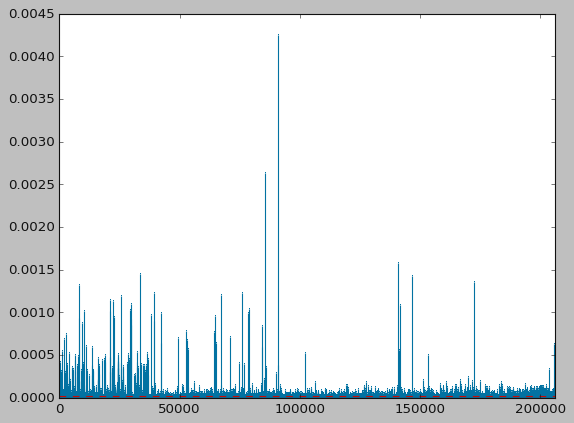

In [107]:
lr_y = lr_df[['real_price']]
lr_X = lr_df.drop(['real_price','town'], axis=1)

yy = np.log(lr_y)['real_price']
XX = lr_X.values

visualizer = CooksDistance()
visualizer.fit(XX, yy)
#visualizer.show()
plt.show()

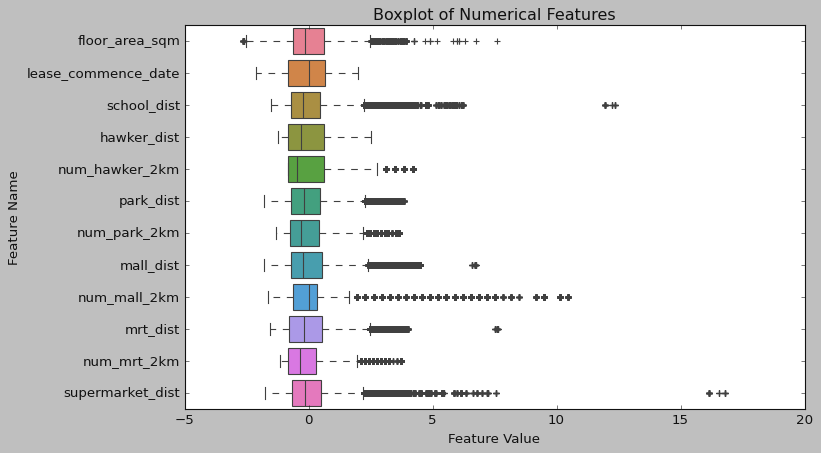

In [108]:
# Plot boxplots for each numerical feature
plt.figure(figsize=(10, 6))
sns.boxplot(data=lr_X[['floor_area_sqm', 'lease_commence_date', 'school_dist', 'hawker_dist', 'num_hawker_2km',
                     'park_dist', 'num_park_2km', 'mall_dist', 'num_mall_2km', 'mrt_dist', 'num_mrt_2km', 'supermarket_dist']], orient='h')
plt.title('Boxplot of Numerical Features')
plt.xlabel('Feature Value')
plt.ylabel('Feature Name')
plt.show()

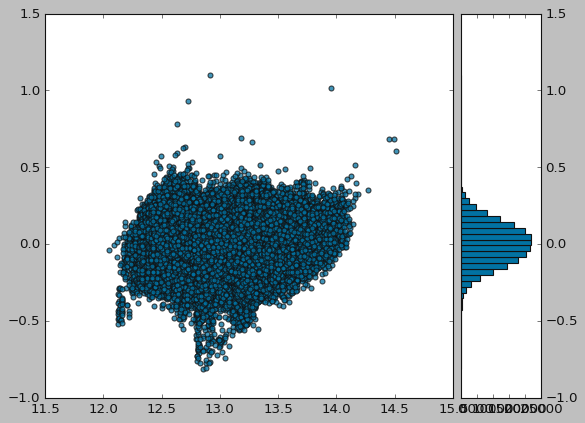

In [109]:
# visualize residuals before outlier removal
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(XX, yy)
#visualizer_residuals.show()
plt.show()

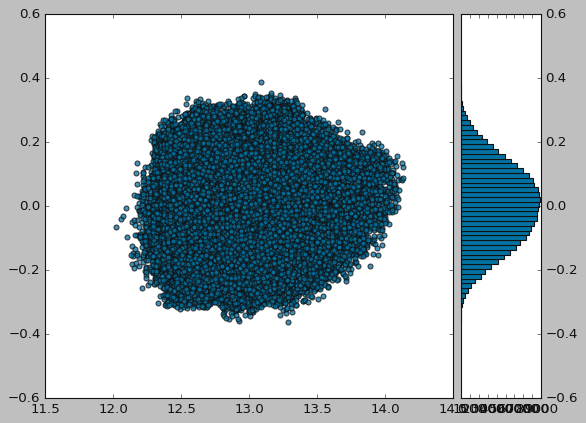

In [110]:
# remove outliers
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = XX[i_less_influential], yy[i_less_influential]
lr_X, lr_y = lr_X[i_less_influential], lr_y[i_less_influential]

# visualize residuals after outliers removal
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
#visualizer_residuals.show()
plt.show()

After removing outliers (~5000, 5.24%), the homoscedaticity became better. The residuals are normally distributed around 0, satisfying the linearity and normality assumptions of the linear model.

# 5. Multiple Linear Regression <a class="anchor" id="5"></a>

In [ ]:
import statsmodels.api as sm # regression analysis
from scipy import stats
from scipy.stats import norm, skew, randint, uniform
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, explained_variance_score, max_error
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor

In [ ]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    ev = explained_variance_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    max_err = max_error(y_true, y_pred)
    
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'R-squared (R2): {r2}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Explained Variance Score: {ev}')
    print(f'Median Absolute Error (MedAE): {medae}')
    print(f'Max Error: {max_err}')

## 5.1. Model Building & Results <a class="anchor" id="5.1"></a>

In [ ]:
lr_y = lr_df[['real_price']]
lr_X = lr_df.drop(['real_price','town'], axis=1)

In [ ]:
# sklearn method, which doesn't give much additional info

lin_reg = LinearRegression()
lin_reg.fit(lr_X, np.log(lr_y))

print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(lr_X, np.log(lr_y))}')

In [ ]:
y_pred = lin_reg.predict(lr_X)
mse = mean_squared_error(np.log(lr_y), y_pred)
r2 = r2_score(np.log(lr_y), y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

In [ ]:
# statsmodel method, which gives more info
import statsmodels.api as sm

X_constant = sm.add_constant(lr_X)
lin_reg = sm.OLS(np.log(lr_y),X_constant).fit()
lin_reg.summary()

Since the sample is huge, most variables/features will be significant although they might not be practically significant.

## 5.2. Homoscedasticity and Normality of Residuals <a class="anchor" id="5.2"></a>

In [ ]:
# Homoscedasticity and Normality of Residuals

plt.style.use('classic')

pred = lin_reg.predict()
resids = lin_reg.resid
resids_studentized = lin_reg.get_influence().resid_studentized_internal

fig = plt.figure(figsize=(10,3))

ax1 = plt.subplot(121)
sns.scatterplot(x=pred, y=resids_studentized, edgecolors='w', alpha=0.9, s=8)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Studentized Residuals')

ax2 = plt.subplot(122)
sns.distplot(resids_studentized, norm_hist=True, hist_kws=dict(edgecolor='w'))
ax2.set_xlabel('Studentized Residual')

plt.show()

Homoscedaticity appears to be satisfied. The residuals are normally distributed around 0, satisfying the linearity and normality assumptions of the linear model.

## 5.3. Feature Importance <a class="anchor" id="5.3"></a>

In [ ]:
!pip install lxml

In [ ]:
plt.style.use('classic')

# Load linear regression results
lr_results = pd.read_html(lin_reg.summary().tables[1].as_html(), header=0, index_col=0)[0]

# Extract coefficients and feature names
coefs = lr_results[['coef']][1:].reset_index().rename(columns={'index':'feature'})
coefs['feature_importance'] = abs(coefs['coef'])

# Sort by feature importance
coefs = coefs.sort_values('feature_importance').reset_index(drop=True)

# Assign colors based on coefficient sign
coefs['color'] = coefs['coef'].apply(lambda x: 'blue' if x > 0 else 'red')

# Plot horizontal bar chart with custom colors
fig, ax = plt.subplots(figsize=(8, 6))
coefs.plot.barh(x='feature', y='feature_importance', color=coefs['color'], figsize=(8, 6), ax=ax)

# Customize legend
colors = {'Positive': 'blue', 'Negative': 'red'}
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in colors.keys()]
legend = plt.legend(handles, colors.keys(), title='Relationship', fontsize='15')
plt.setp(legend.get_title(), fontsize='17')

# Customize axis labels and title
plt.xlabel('Absolute Coefficient Values', size=15)
plt.ylabel('Features', size=15)
plt.title('Linear Regression Feature Importance', size=15)
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top

plt.show()

It seems that __region__ is the feature that drives resale prices the most:
* The __Central region__ was used as the baseline against which all other regions are compared to. 
* This means that all the other regions tend to be sold lower as compared to the __Central area__. 

__Floor area__, __lease commence date__ and __special flat models__ are also positive drivers of resale prices while distance to nearest __hawker center__ is a negative driver.

# 6. Model Selection <a class="anchor" id="6"></a>

## 6.1. Multiple Linear Regression <a class="anchor" id="6.1"></a>

In [ ]:
# lr_y = lr_df[['real_price']]
# lr_X = lr_df.drop(['real_price','town'], axis=1)
# lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=42)

In [ ]:
# lr_dr - scaled

lr_y = lr_df[['real_price']]
lr_X = lr_df.drop(['real_price', 'town'], axis=1)
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=42)

start_time = dt.now()

lr = LinearRegression()
lr.fit(lr_X_train, np.log(lr_y_train))

end_time = dt.now()
fit_time = end_time - start_time
print(f"MLR fit time: {fit_time}")

In [ ]:
evaluate(np.log(lr_y_test), lr.predict(lr_X_test))

In [ ]:
# scatterplot of y (observed) and yhat (predicted)

plt.style.use('classic')

fig = plt.figure(figsize=(8, 5))
ax = sns.scatterplot(x=np.log(lr_y_test)['real_price'], y=lr.predict(lr_X_test).squeeze(), edgecolors='w', alpha=0.9, s=8)
ax.set_xlabel('Actual Prices')
ax.set_ylabel('Predicted Prices')
ax.annotate('R-Squared: ' + str(format(round(lin_reg.rsquared_adj, 2), '.2f')), xy=(0, 1), xytext=(25, -25),
            xycoords='axes fraction', textcoords='offset points', fontsize=15)
plt.title('MLR Prediction vs Observation')

# Set y-axis lower limit
ax.set_xlim(11.5, 14.5)
ax.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax.get_xlim()
ylim = ax.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")


plt.show()

In [ ]:
""" Train Test Split (at 6.Random Forest)
y = df[['real_price']]
X = df.drop(['real_price','town', 'year'], axis=1)"""

y = df[['real_price']]
X = df.drop(['real_price', 'town', 'year'], axis=1)

numerical_columns_selector = selector(dtype_exclude=object)
numeric_features = numerical_columns_selector(X)
numeric_preprocessor = StandardScaler()
preprocessor = ColumnTransformer([('standard_scaler', numeric_preprocessor, numeric_features)])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, np.log(y_train))

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(np.log(y_test), y_pred)
r2 = r2_score(np.log(y_test), y_pred)
print('Linear Regression:')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

In [ ]:
y_pred

## 6.2. Stohastic Gradient Descent Regression (SGD) <a class="anchor" id="6.2"></a>

In [ ]:
# lr_y = lr_df[['real_price']]
# lr_X = lr_df.drop(['real_price','town'], axis=1)
# lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=42)

In [ ]:
# :) np.log lr_df

start_time = dt.now()

sgd = SGDRegressor()
sgd.fit(lr_X_train, np.log(lr_y_train))
y_pred = sgd.predict(lr_X_test)

end_time = dt.now()
fit_time = end_time - start_time
print(f"SGD fit time: {fit_time}")

In [ ]:
evaluate(np.log(lr_y_test), y_pred)

In [ ]:
# scatterplot of y (observed) and yhat (predicted)

plt.style.use('classic')

fig = plt.figure(figsize=(8, 5))
ax = sns.scatterplot(x=np.log(lr_y_test)['real_price'], y=sgd.predict(lr_X_test), edgecolors='w', alpha=0.9, s=8)
ax.set_xlabel('Actual Prices')
ax.set_ylabel('Predicted Prices')
ax.annotate('R-Squared: ' + str(format(round(lin_reg.rsquared_adj, 2), '.2f')), xy=(0, 1), xytext=(25, -25),
            xycoords='axes fraction', textcoords='offset points', fontsize=15)
plt.title('SGD Prediction vs Observation')

# Set y-axis lower limit
ax.set_xlim(11.5, 14.5)
ax.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax.get_xlim()
ylim = ax.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")


plt.show()

In [ ]:
# Set the style
plt.style.use('classic')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: MLR Prediction vs Observation
ax1 = sns.scatterplot(x=np.log(lr_y_test)['real_price'], y=lr.predict(lr_X_test).squeeze(), edgecolors='w', alpha=0.9, s=8, ax=axs[0])
ax1.set_xlabel('Actual Prices')
ax1.set_ylabel('Predicted Prices')
ax1.annotate('R-Squared: ' + str(format(round(lin_reg.rsquared_adj, 2), '.2f')), xy=(0, 1), xytext=(25, -25),
              xycoords='axes fraction', textcoords='offset points', fontsize=15)

# Set y-axis lower limit
ax1.set_xlim(11.5, 14.5)
ax1.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax1.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")


ax1.set_title('MLR Prediction vs Observation')


#################

# Second subplot: SGD Prediction vs Observation
ax2 = sns.scatterplot(x=np.log(lr_y_test)['real_price'], y=sgd.predict(lr_X_test), edgecolors='w', alpha=0.9, s=8, ax=axs[1])
ax2.set_xlabel('Actual Prices')
ax2.set_ylabel('Predicted Prices')
ax2.annotate('R-Squared: ' + str(format(round(lin_reg.rsquared_adj, 2), '.2f')), xy=(0, 1), xytext=(25, -25),
              xycoords='axes fraction', textcoords='offset points', fontsize=15)

# Set y-axis lower limit
ax2.set_xlim(11.5, 14.5)
ax2.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax2.get_xlim()
ylim = ax2.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax2.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")

ax2.set_title('SGD Prediction vs Observation')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## 6.3. Random Forest Regression <a class="anchor" id="6.3"></a>

In [ ]:
# :) np.log

start_time = dt.now()

rmr = make_pipeline(preprocessor, RandomForestRegressor(max_depth=2, random_state=0))
rmr.fit(X_train, np.log(y_train))

end_time = dt.now()
fit_time = end_time - start_time
print(f"Random Forest fit time: {fit_time}")

In [ ]:
evaluate(np.log(y_test), rmr.predict(X_test))

In [ ]:
# scatterplot of y (observed) and yhat (predicted)

plt.style.use('classic')

fig = plt.figure(figsize=(5, 3))
ax = sns.scatterplot(x=np.log(y_test)['real_price'], y=rmr.predict(X_test), edgecolors='w', alpha=0.9, s=8)
ax.set_xlabel('Actual Prices')
ax.set_ylabel('Predicted Prices')
ax.annotate('R-Squared: 0.51', xy=(0, 1), xytext=(25, -25),
            xycoords='axes fraction', textcoords='offset points', fontsize=15)
plt.title('Random Forest Prediction vs Observation')

# Set y-axis lower limit
ax.set_xlim(11.5, 14.5)
ax.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax.get_xlim()
ylim = ax.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")

plt.show()

## 6.4. Gradient Boosting Regression <a class="anchor" id="6.4"></a>

In [ ]:
# np.log

start_time = dt.now()

gb = make_pipeline(preprocessor, GradientBoostingRegressor())
gb.fit(X_train, np.log(y_train))

end_time = dt.now()
fit_time = end_time - start_time
print(f"Gradient Boosting fit time: {fit_time}")

In [ ]:
evaluate(np.log(y_test), gb.predict(X_test))

In [ ]:
# scatterplot of y (observed) and yhat (predicted)

plt.style.use('classic')

fig = plt.figure(figsize=(5, 3))
ax = sns.scatterplot(x=np.log(y_test)['real_price'], y=gb.predict(X_test), edgecolors='w', alpha=0.9, s=8)
ax.set_xlabel('Actual Prices')
ax.set_ylabel('Predicted Prices')
ax.annotate('R-Squared: 0.88', xy=(0, 1), xytext=(25, -25),
            xycoords='axes fraction', textcoords='offset points', fontsize=15)
plt.title('GB Prediction vs Observation')

# Set y-axis lower limit
ax.set_xlim(11.5, 14.5)
ax.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax.get_xlim()
ylim = ax.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")

plt.show()

## 6.5. Extreme Gradient Boosting Regression <a class="anchor" id="6.5"></a>

In [ ]:
# np.log

start_time = dt.now()

exgb = make_pipeline(preprocessor, XGBRegressor())
exgb.fit(X_train, np.log(y_train))

end_time = dt.now()
fit_time = end_time - start_time
print(f"XGBoosing fit time: {fit_time}")

In [ ]:
evaluate(np.log(y_test), exgb.predict(X_test))

In [ ]:
# scatterplot of y (observed) and yhat (predicted)

plt.style.use('classic')

fig = plt.figure(figsize=(5, 3))
ax = sns.scatterplot(x=np.log(y_test)['real_price'], y=exgb.predict(X_test), edgecolors='w', alpha=0.9, s=8)
ax.set_xlabel('Actual Prices')
ax.set_ylabel('Predicted Prices')
ax.annotate('R-Squared: 0.91', xy=(0, 1), xytext=(25, -25),
            xycoords='axes fraction', textcoords='offset points', fontsize=15)
plt.title('XGB Prediction vs Observation')

# Set y-axis lower limit
ax.set_xlim(11.5, 14.5)
ax.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax.get_xlim()
ylim = ax.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")

plt.show()

In [ ]:
# scatterplot of y (observed) and yhat (predicted) for Gradient Boosting

plt.style.use('classic')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for Gradient Boosting
ax1 = sns.scatterplot(x=np.log(y_test)['real_price'], y=gb.predict(X_test), edgecolors='w', alpha=0.9, s=8, ax=axes[0])
ax1.set_xlabel('Actual Prices')
ax1.set_ylabel('Predicted Prices')
ax1.annotate('R-Squared: 0.88', xy=(0, 1), xytext=(25, -25),
             xycoords='axes fraction', textcoords='offset points', fontsize=15)
ax1.set_title('GB Prediction vs Observation')

# Set y-axis lower limit
ax1.set_xlim(11.5, 14.5)
ax1.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax1.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")


#######################

# Plot for Extreme Gradient Boosting
ax2 = sns.scatterplot(x=np.log(y_test)['real_price'], y=exgb.predict(X_test), edgecolors='w', alpha=0.9, s=8, ax=axes[1])
ax2.set_xlabel('Actual Prices')
ax2.set_ylabel('Predicted Prices')
ax2.annotate('R-Squared: 0.91', xy=(0, 1), xytext=(25, -25),
             xycoords='axes fraction', textcoords='offset points', fontsize=15)
ax2.set_title('XGB Prediction vs Observation')

# Set y-axis lower limit
ax2.set_xlim(11.5, 14.5)
ax2.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax2.get_xlim()
ylim = ax2.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax2.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")

plt.tight_layout()
plt.show()

### 6.5.1. HPO (Hyper-Parameter Optimization) & Cross-Validation <a class="anchor" id="6.5.1"></a>

In [ ]:
# lr_y = lr_df[['real_price']]
# lr_X = lr_df.drop(['real_price','town'], axis=1)
# lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=42)

In [ ]:
# Cross-Validation for XGB

# evaluation exgb

y = df[['real_price']]
X = df.drop(['real_price', 'town', 'year'], axis=1)

In [ ]:
cv_results_xgb = cross_validate(exgb, X, y, cv=5)
cv_results_xgb = pd.DataFrame(cv_results_xgb)
cv_results_xgb

In [ ]:
# Before HPO

print(
    "Generalization score without hyperparameters tuning:\n"
    f"{cv_results_xgb['test_score'].mean():.3f} +/- {cv_results_xgb['test_score'].std():.3f}"
)

In [ ]:
import numpy as np
# !pip install numpy==1.24.0
# !pip show numpy | grep Version

In [ ]:
# HPO using random research

lr_y = lr_df[['real_price']]
lr_X = lr_df.drop(['real_price','town'], axis=1)

params = {
    'xgbregressor__n_estimators': randint(50, 1000),
    'xgbregressor__max_depth': randint(3, 10),
    'xgbregressor__learning_rate': uniform(0.01, 0.3),
    'xgbregressor__subsample': uniform(0.6, 0.4),
    'xgbregressor__colsample_bytree': uniform(0.6, 0.4),
}

random_search = RandomizedSearchCV(exgb, param_distributions=params,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                   verbose=1, n_jobs=-1,random_state=42)

random_search.fit(X, np.log(y))
print("Best Parameters: ", random_search.best_params_)

In [ ]:
# :(  train new XGB with optimized Hyper-Parameter


best_params = random_search.best_params_
exgb_new = make_pipeline(preprocessor, xgb.XGBRegressor(**best_params))
exgb_new.fit(X_train, np.log(y_train))

evaluate(np.log(y_test), exgb_new.predict(X_test))

## 6.6. Neural Network <a class="anchor" id="6.6"></a>

In [ ]:
import tensorflow as tf

In [ ]:
"""
lr_y = lr_df[['real_price']]
lr_X = lr_df.drop(['real_price','town'], axis=1)"""
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=42)

In [ ]:
nn = tf.keras.models.Sequential()

nn.add(tf.keras.layers.Dense(units=64, activation='relu'))
nn.add(tf.keras.layers.Dense(units=32, activation='relu'))
nn.add(tf.keras.layers.Dense(units=1))

nn.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
start_time = dt.now()

nn.fit(lr_X_train, np.log(lr_y_train), batch_size=32, epochs=50)

end_time = dt.now()
fit_time = end_time - start_time
print(f"Neural Network fit time: {fit_time}")

In [ ]:
# :) finally!

evaluate(np.log(lr_y_test), nn.predict(lr_X_test))

In [ ]:
# scatterplot of y (observed) and yhat (predicted)

plt.style.use('classic')

fig = plt.figure(figsize=(5, 3))
ax = sns.scatterplot(x=np.log(y_test)['real_price'], y=nn.predict(lr_X_test).squeeze(), edgecolors='w', alpha=0.9, s=8)
ax.set_xlabel('Actual Prices')
ax.set_ylabel('Predicted Prices')
ax.annotate('R-Squared: 0.9', xy=(0, 1), xytext=(25, -25),
            xycoords='axes fraction', textcoords='offset points', fontsize=15)
plt.title('Neural Network Prediction vs Observation')

# Set y-axis lower limit
ax.set_xlim(11.5, 14.5)
ax.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax.get_xlim()
ylim = ax.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")

plt.show()

In [ ]:
# scatterplot of y (observed) and yhat (predicted)

plt.style.use('classic')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for Extreme Gradient Boosting
ax1 = sns.scatterplot(x=np.log(y_test)['real_price'], y=exgb.predict(X_test), edgecolors='w', alpha=0.9, s=8, ax=axes[0])
ax1.set_xlabel('Actual Prices')
ax1.set_ylabel('Predicted Prices')
ax1.annotate('R-Squared: 0.91', xy=(0, 1), xytext=(25, -25),
             xycoords='axes fraction', textcoords='offset points', fontsize=15)
ax1.set_title('XGB Prediction vs Observation')

# Set y-axis lower limit
ax1.set_xlim(11.5, 14.5)
ax1.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax1.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")


# Plot for Neural Network
ax2 = sns.scatterplot(x=np.log(y_test)['real_price'], y=nn.predict(lr_X_test).squeeze(), edgecolors='w', alpha=0.9, s=8)
ax2.set_xlabel('Actual Prices')
ax2.set_ylabel('Predicted Prices')
ax2.annotate('R-Squared: 0.9', xy=(0, 1), xytext=(25, -25),
             xycoords='axes fraction', textcoords='offset points', fontsize=15)
ax2.set_title('Neural Network Prediction vs Observation')

# Set y-axis lower limit
ax2.set_xlim(11.5, 14.5)
ax2.set_ylim(11.5, 14.5)

# Plot diagonal line
xlim = ax2.get_xlim()
ylim = ax2.get_ylim()
min_val = min(min(xlim), min(ylim))
max_val = max(max(xlim), max(ylim))
ax2.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")

plt.tight_layout()
plt.show()

## Model Evaluation

In [ ]:
models = ['mlr', 'sgd', 'rf', 'gb', 'xgb', 'nn']
info = {'mlr': [lr.predict(lr_X_test).squeeze(), 0.83, 'Multiple Linear Regression'],
          'sgd': [sgd.predict(lr_X_test), 0.83, 'Stochastic Gradient Descent'],
          'rf': [rmr.predict(X_test), 0.51, 'Random Forest Regression'], 
          'gb': [gb.predict(X_test), 0.89, 'Gradient Boost Regression'],
          'xgb': [exgb.predict(X_test), 0.91, 'XGBoost Regression'],
          'nn': [nn.predict(lr_X_test).squeeze(), 0.9, 'Neural Network Regression']}

plt.figure(figsize=(18, 12))

for i, m in enumerate(models, start=1):
    plt.subplot(2, 3, i)
    ax = sns.scatterplot(x=np.log(y_test)['real_price'], y=info[m][0], edgecolors='w', alpha=0.9, s=8)
    ax.set_xlabel('Actual Prices')
    ax.set_ylabel('Predicted Prices')
    ax.annotate('R-Squared: {}'.format(info[m][1]), xy=(0, 1), xytext=(25, -25),
                xycoords='axes fraction', textcoords='offset points', fontsize=15)
    plt.title('{}'.format(info[m][2]))

    ax.set_xlim(11.5, 14.5)
    ax.set_ylim(11.5, 14.5)
    plt.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")
    
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()
#     min_val = min(min(xlim), min(ylim))
#     max_val = max(max(xlim), max(ylim))
#     ax.plot([min_val, max_val], [min_val, max_val], ls="--", c="r")

In [ ]:
# start_time = datetime.now()
# ### fit
# end_time = datetime.now()
# fit_time = end_time - start_time
# print(f"Model fit time: {fit_time}")